In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cdms
from qetpy.utils import lowpassfilter, energy_resolution
from qetpy import calc_psd, autocuts
#from qetpy.core import calc_csd
from scipy.optimize import curve_fit
import sys
sys.path.append('/sdf/home/a/aditi/notebooks/DMQIS/')
from QETpy_copy.qetpy.core import calc_csd, calc_corrcoeff_from_csd, Noise
from QETpy_copy.qetpy.utils import fold_spectrum 
from QETpy_copy.qetpy.plotting import plot_csd
import QETpy_v163.qetpy as qp
import math
from noise_model import TES

/sdf/home/a/aditi/notebooks/DMQIS/QETpy_v163/qetpy/core/didv/_plot_didv.py:182: DeprecationWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)')
/sdf/home/a/aditi/notebooks/DMQIS/QETpy_v163/qetpy/core/didv/_plot_didv.py:183: DeprecationWarning: invalid escape sequence '\m'
  ax.set_ylabel('Amplitude ($\mu$A)')
/sdf/home/a/aditi/notebooks/DMQIS/QETpy_v163/qetpy/core/didv/_plot_didv.py:452: DeprecationWarning: invalid escape sequence '\s'
  label='1-$\sigma$ Bounds',
/sdf/home/a/aditi/notebooks/DMQIS/QETpy_v163/qetpy/core/didv/_plot_didv.py:555: DeprecationWarning: invalid escape sequence '\O'
  ax.set_ylabel('Re($dI/dV$) ($\Omega^{-1}$)')
/sdf/home/a/aditi/notebooks/DMQIS/QETpy_v163/qetpy/core/didv/_plot_didv.py:567: DeprecationWarning: invalid escape sequence '\O'
  ax.set_ylabel('Im($dI/dV$) ($\Omega^{-1}$)')
/sdf/home/a/aditi/notebooks/DMQIS/QETpy_v163/qetpy/core/didv/_plot_didv.py:602: DeprecationWarning: invalid escape sequence '\O'
  ax.set_ylabel('Abs($dI/dV$) ($

In [2]:
print(qp.__version__)

1.6.3


In [3]:
channel_list = ["PAS1","PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"]
chan_tes = ['PBS1','PAS1','PCS1','PFS1','PDS1','PES1','PBS2','PFS2','PES2','PAS2','PDS2','PCS2'] # Chan names in TES order
detector = 1
ADC2amps = 1/2**16 *8/5e3 /2.4/4 # multiply ADCu by this to get Amps
phonon_shift= 65536.0/2
runs = [12,15,16]#,'T15','T20','T25','T30','T32','T35','T40','T45','T50','T55','T58']
raw_filepath = {12:'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/',15:'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF15/',
                16:'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/',
                'T15':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/','T20':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/',
                'T25':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/','T30':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/',
                'T32':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/','T35':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/',
                'T40':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/','T45':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/',
                'T50':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/','T55':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/',
                'T58':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/'}


files_selected = {15:['RUN17058_DUMP0000.mid.gz'],16:{'RUN18042_DUMP0000.mid.gz'}}#,'RUN17864_DUMP0000.mid.gz'}}

title_map = {12:{'PAS1': 'NW A', 'PBS1':'NW B', 'PCS1':'TAMU NFC A', 'PDS1': 'SiC sq A', 'PES1': 'SiC sq B','PFS1':'TAMU NFC B',
                 'PAS2': 'SiC NFC1 B', 'PBS2': 'SiC NFC2 A', 'PCS2': 'SiC NFH B', 'PDS2': 'SiC NFH A', 'PES2':'SiC NFC1 A', 'PFS2': 'SiC NFC2 B'},
             15:{"PAS1": "SiC NFC3 B", "PBS1": "SiC NFC3 A","PCS1": "SiC NFH A","PDS1": "TAMU NFH A","PES1": "TAMU NFH B",
             "PFS1": "SiC NFH B","PAS2": "SiC NFC1 B","PBS2": "SiC NFC2 A","PCS2": "TAMU NFC B","PDS2": "TAMU NFC A",
             "PES2": "SiC NFC1 A","PFS2": "SiC NFC2 B"},
            16:{"PAS1": "SiC NFC3 B", "PBS1": "SiC NFC3 A","PCS1": "SiC NFH A","PDS1": "TAMU NFH A","PES1": "TAMU NFH B",
             "PFS1": "SiC NFH B","PAS2": "SiC NFC1 B","PBS2": "SiC NFC2 A","PCS2": "TAMU NFC B","PDS2": "TAMU NFC A",
             "PES2": "SiC NFC1 A","PFS2": "SiC NFC2 B"}}

# Channels of interest in R12 are PFS1 (TAMU NFC B), PFS2 (SiC NFC2 B), PAS2 (SiC NFC1 B), PCS2 (SiC NFH B)

chan_tes = ['PBS1','PAS1','PCS1','PFS1','PDS1','PES1','PBS2','PFS2','PES2','PAS2','PDS2','PCS2'] # Chan names in TES order

In [6]:
event_dframe={}
odb={}
for r in runs[2:]:
    for f in files_selected[r]:
        #EN = list(EN_Ba['EventNumber'][:50].astype(int))
        fpath = raw_filepath[r]
        if('16439' in f): fpath = raw_filepath[r][:-2]+'4/'
        myreader = cdms.rawio.IO.RawDataReader(filepath=fpath+f,verbose=False)
        temp=myreader.read_events(output_format = 2)
        odb[f] = myreader.get_full_odb()
        event_dframe[f]=temp

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18042_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18042_DUMP0000.mid.gz
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18042_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18042_DUMP0000.mid.gz
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18042_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn

In [6]:
odb[f]['/Detectors/Det01/Settings/Phonon/QETBias (uA)']

[75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0]

25


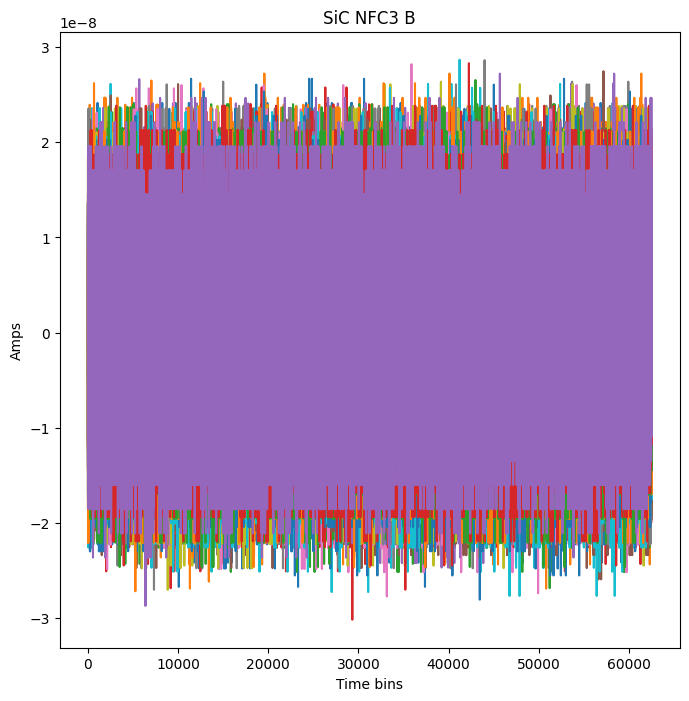

25


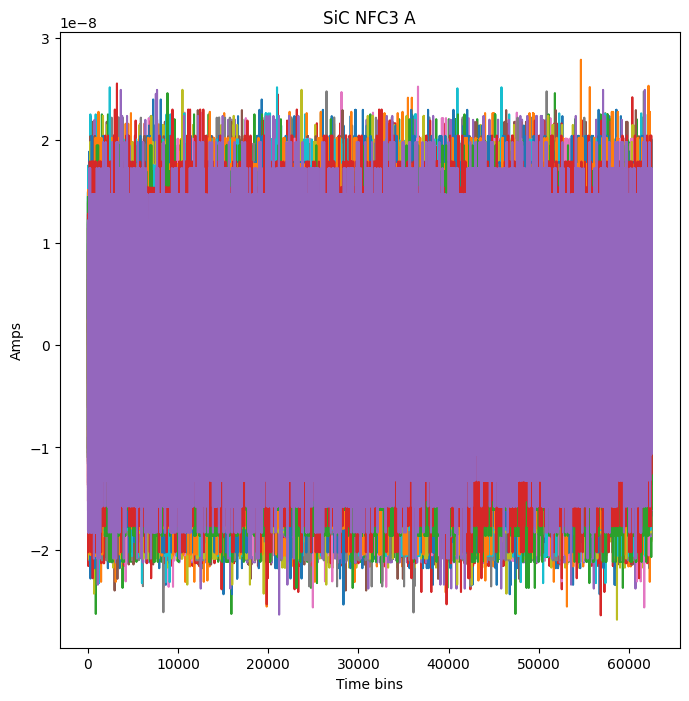

26


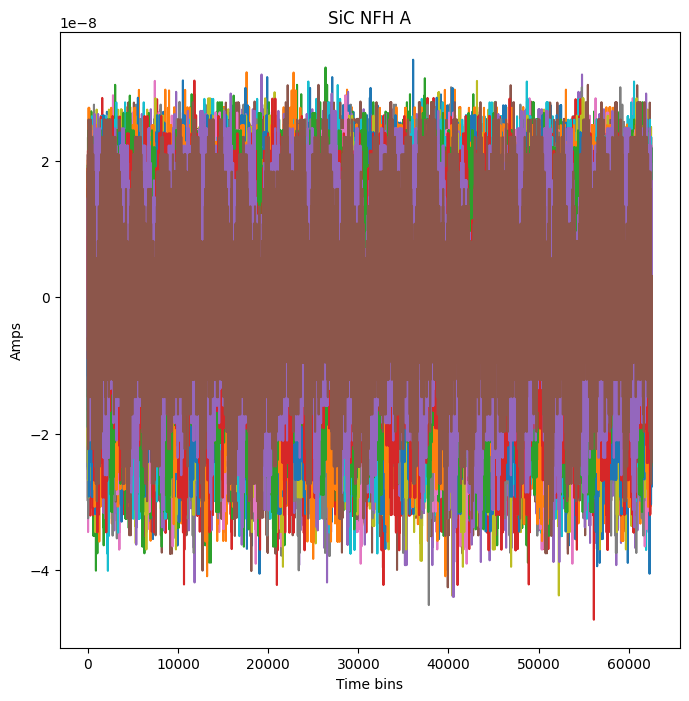

26


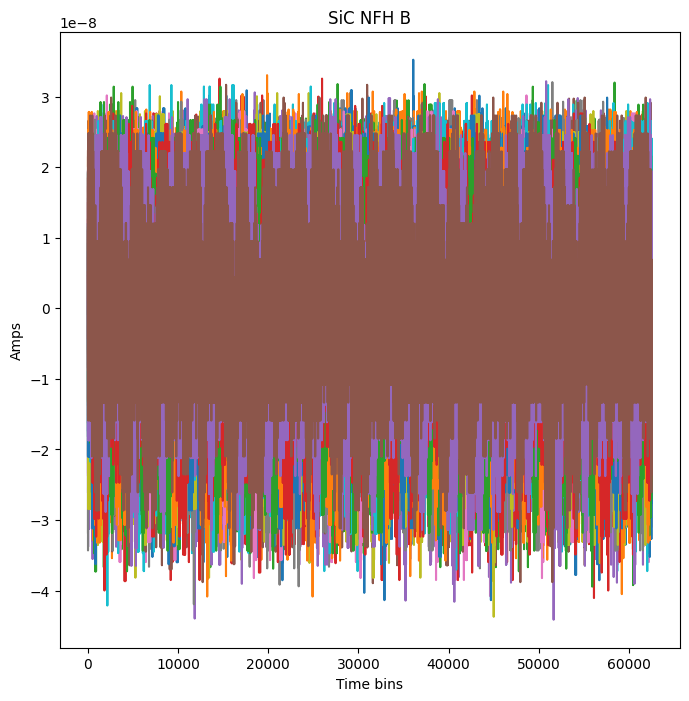

26


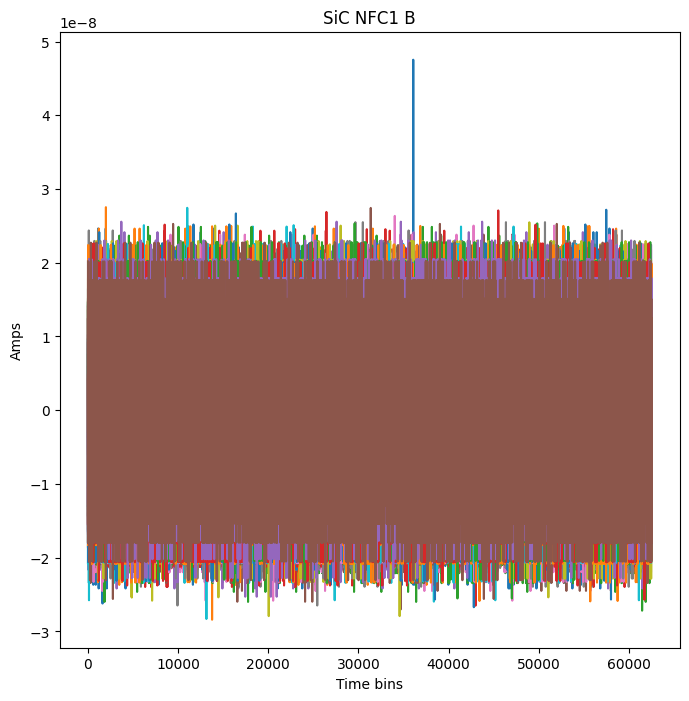

25


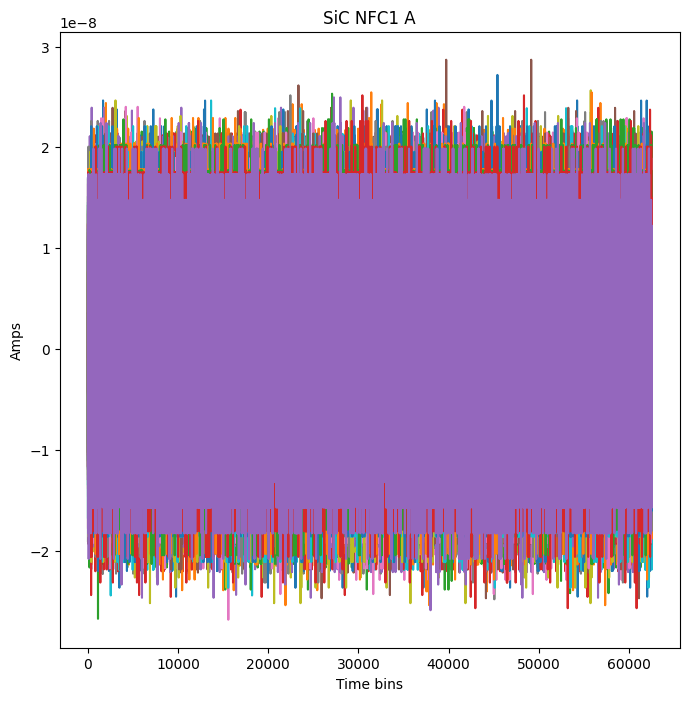

12


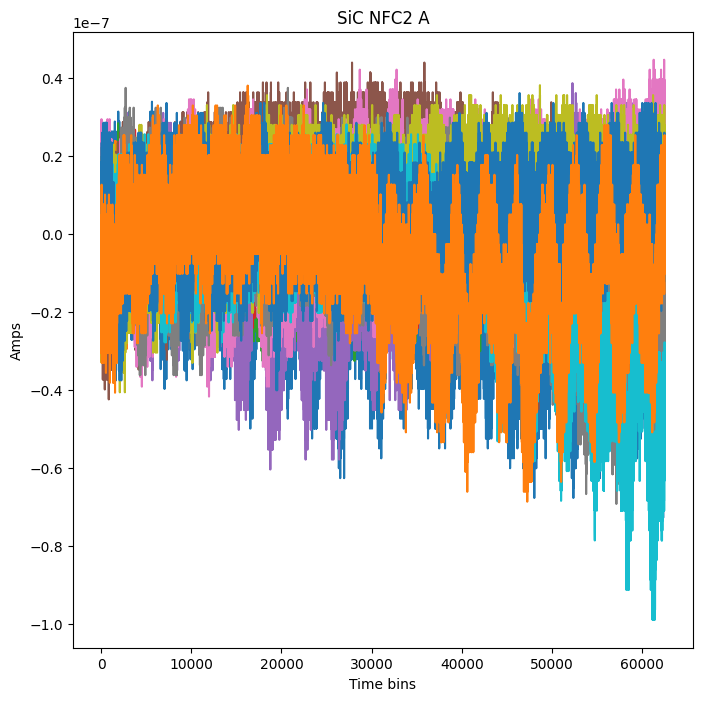

12


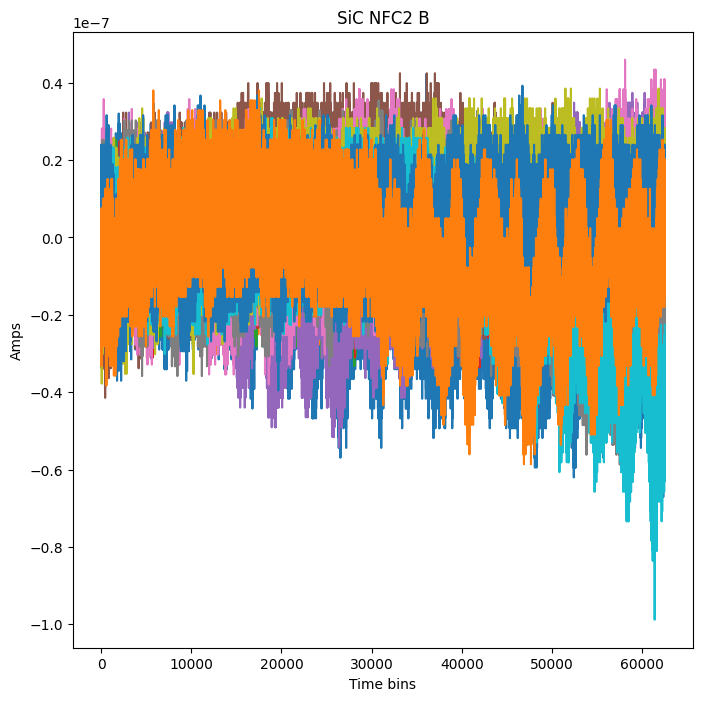

24


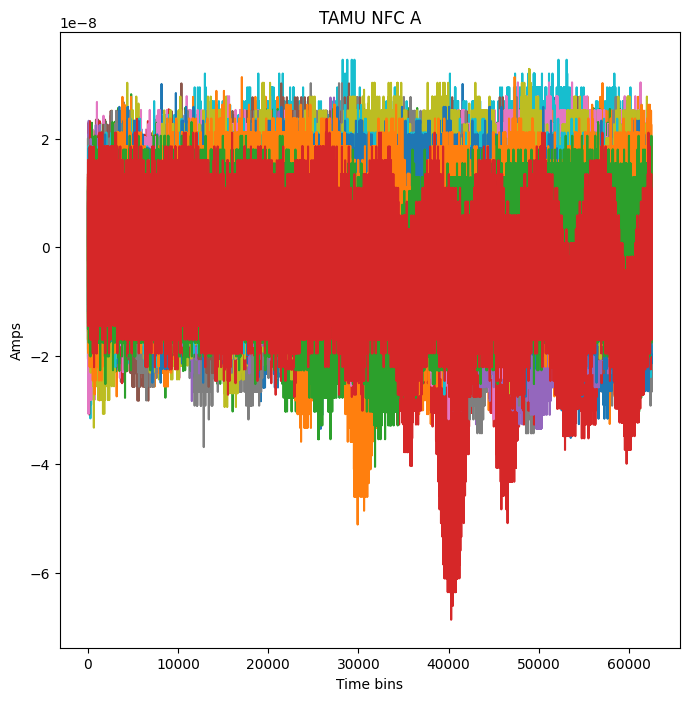

26


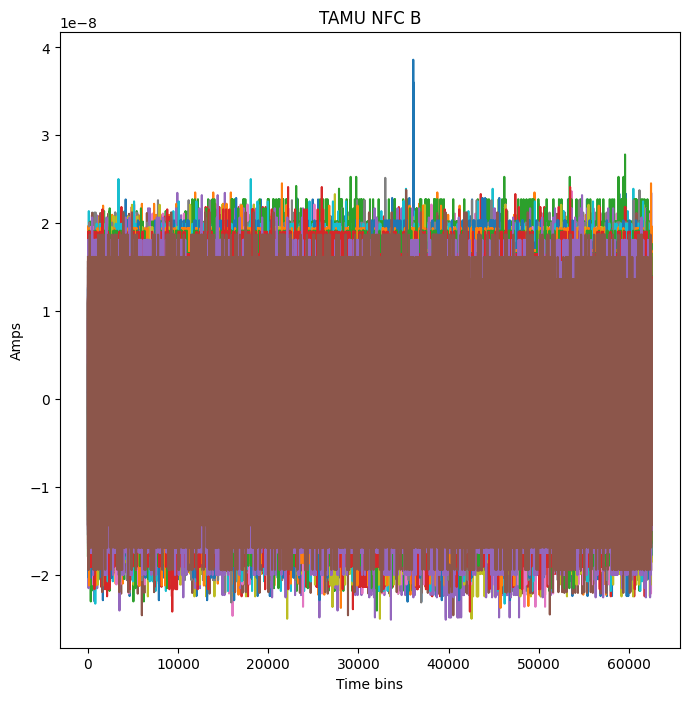

In [39]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})
fs = 625e3

psd_traces = {}
psd_cuts = {}
for r in runs[2:]:
    for f in files_selected[r]:
        n = len(event_dframe[f])
        tempchan = {}
        tempcut = {}
        #if(r == 15): ch = 'PFS1'
        # if(r == 14): ch = 'PFS2'
        # if(r == 12): ch = 'PCS2'
        
        for c in ['PAS1','PBS1','PCS1','PFS1', 'PAS2', 'PES2','PBS2','PFS2','PDS2','PCS2']:
        #for c in ['PAS1','PCS1','PAS2', 'PBS2']:
            # if(r == 15): ch = c
            # if(r == 12): ch = r12_chanmap[c]
            ch = c
            temp=[]
            for i in range(n):
                t0 = event_dframe[f][0]['event']['EventTime']
                if(event_dframe[f][i]['event']['EventTime']-t0>10): continue
                
                trace = (event_dframe[f][i][f"Z{detector}"][ch]-phonon_shift)*ADC2amps#- offsets[ch][r]*1e-6
                trace -= np.mean(trace[:10000])
                # For R15
                # if(('TAMU NFH' in title_map[r][c]) or ('SiC NFC1' in title_map[r][c]) or ('SiC NFC2' in title_map[r][c])): 
                #     maxcut = 1.5e-7 + np.mean(trace)
                # else: maxcut = 0.5e-7 + np.mean(trace)
                
                # if(max(trace)>1e3*abs(np.mean(trace))): continue
                # elif(abs(min(trace))>1e3*abs(np.mean(trace))): continue
                
                if(max(trace)>5e-8 or abs(min(trace))>1e-7): 
                    continue
                #     if('NFH' in title_map[15][c] and min(trace)<-0.25e-6):
                #         continue
                temp.append(trace)
                # if(i<10):
                #     plt.plot(trace,alpha=0.5)

            #tempcut[ch]=autocuts(np.array(temp),fs=fs)
            print(len(temp))
            tempchan[ch] = np.array(temp)
            
            for i in range(len(tempchan[ch])):
                plt.plot(tempchan[ch][i])
            plt.title(title_map[15][c])
            plt.xlabel('Time bins')
            plt.ylabel('Amps')
            #plt.xlim(0,500)
            plt.show()
        psd_traces[f] = tempchan
        psd_cuts[f] = tempcut

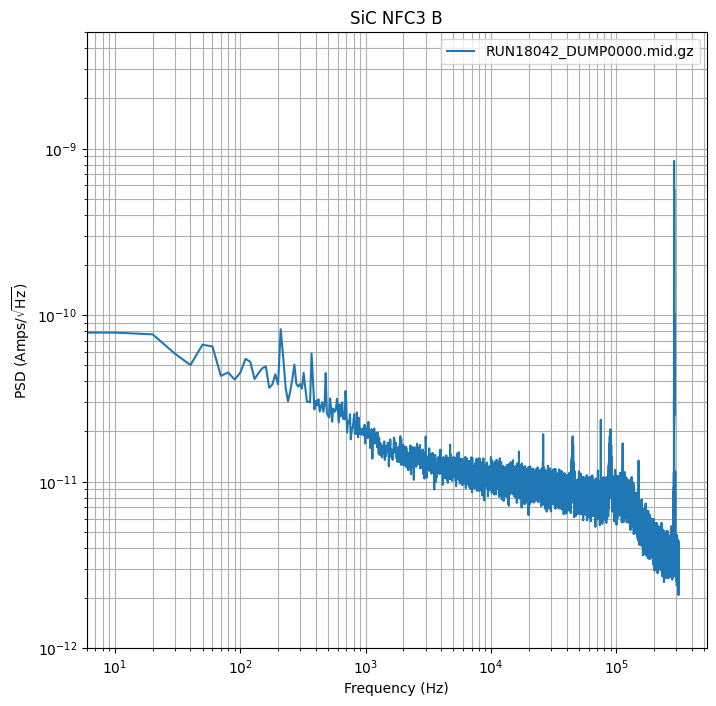

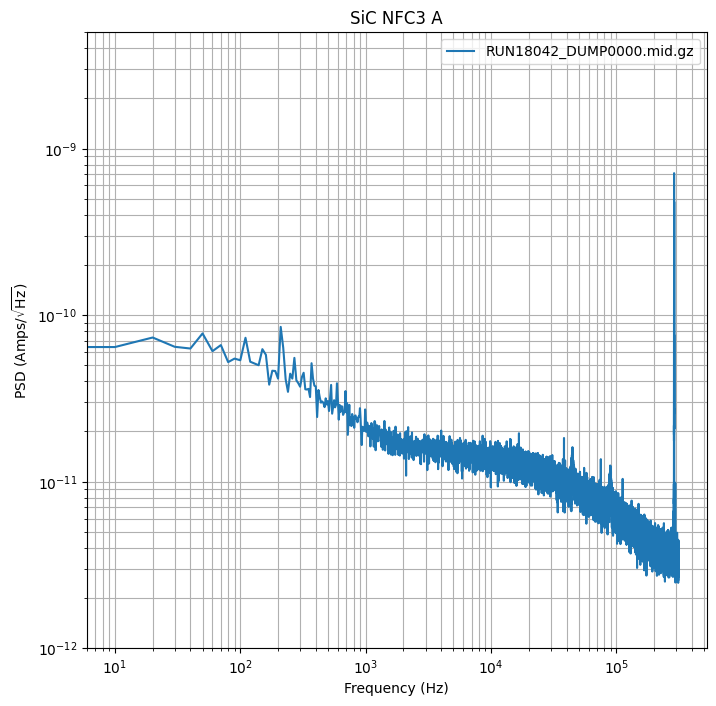

In [40]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})
avg_psd={}
freqs = {}
fs = 625e3
tempf=[]

# tempf2 = []
clist = ['PAS1','PBS1']#,'PCS1','PFS1', 'PAS2', 'PES2','PBS2','PFS2','PDS2','PCS2']
#i=0
for c in clist:#
#for c in ['PAS1','PCS1','PAS2', 'PBS2']:
    for r in runs[2:]:
        ch = c
        #if(r == 15): ch = c
        #if(r == 12): ch  = r12_chanmap[c]
        for f in files_selected[r]:
            # if(f == 'RUN18041_DUMP0000.mid.gz'):
            #if(i%2 == 0):
            #cuts = (psd_cuts[f][ch])# & psd_cuts[f][clist[i+1]])
            tempf.append(psd_traces[f][ch])
            #print(len(psd_traces[f][ch]),len(psd_traces[f][ch][cuts]))
            # else:
            #     tempf2.append(psd_traces[f][ch])
            freqs[f+' '+ch], avg_psd[f+' '+ch] = calc_psd(np.array(psd_traces[f][ch]), fs = fs, folded_over=True)
            plt.loglog(freqs[f+' '+ch], np.sqrt(avg_psd[f+' '+ch]),label=f)
        
    #i+=1
    plt.legend()
    plt.grid(which='both',axis='both')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'PSD (Amps/$\sqrt{\text{Hz}}$)')
    plt.title(title_map[16][c])
    plt.ylim(1e-12,5e-9)
    plt.show()
traces={list(files_selected[r])[0]:tempf}#,forder[1]:tempf[1]}

## CSD

In [8]:
calc_csd?

Signature: calc_csd(array, fs=1.0, folded_over=False, use_hann_window=False)
Docstring:
Calculate and return the CSD of in Amps^2/Hz

Parameters
----------
array : 2D numpy array [channels, samples]  
     or 3D array [traces, channels, samples]

    Array to calculate CSD of in unit of Amps

fs : float, optional
    Sample rate of the data being taken, assumed to be in units of Hz.

folded_over : bool, optional
    Boolean value specifying whether or not the CSD is two-sided or 
    folder

use_hann_window : bool, optional
    Specifies whether to use a Hann window on the CSD calculation.
    If false, defaults to a boxcar window, identical to no window.
        
Returns
-------
f : ndarray
    Array of sample frequencies
csd : 3darray
    cross power spectral density of 'array' in units of Amps^2/Hz
    (return mean csd if multiple traces)
    
File:      ~/notebooks/DMQIS/QETpy_copy/qetpy/core/_noise.py
Type:      function

In [31]:
plot_csd?

Signature:
plot_csd(
    noise=None,
    csd=None,
    csd_freqs=None,
    channels=None,
    title=None,
    whichcsd=['02'],
    lgcreal=True,
    lgcsave=False,
    savepath=None,
    figsize=(8, 5),
)
Docstring:
Function to plot the cross channel noise spectrum referenced to the TES line in
units of Amperes^2/Hz

Parameters
----------
noise : Object, optional
    Noise object to be plotted
csd : 3D numpy array 
     csd in unit of Amps^2/Hz
csd_freqs : 1D numpy array
    frequency array
channels : list of string (optional)
    channel names, 
   If None, default names are "channel1", "channel2", etc
title : str 
    title of the figure   
whichcsd : list, optional
    a list of strings, where each element of the list refers to the pair of 
    indices of the desired csd plot
lgcreal : boolean, optional
    If True, the Re(csd) is plotted. If False, the Im(csd) is plotted
lgcsave : boolean, optional
    If True, the figure is saved in the user provided directory
savepath : str, opti

In [ ]:
# Testing if this works
# two-sided CSD
csd_traces = np.transpose(traces[f],axes=(1,0,2))
fs = 625e3
csd_freqs, csd = calc_csd(csd_traces, fs=fs, folded_over=True)

# Correlation coefficient
# leplot_csd(whichcsd=['66','26'])t's fold first
csd_freqs_folded, csd_folded = fold_spectrum(csd, fs)
corrcoeff = calc_corrcoeff_from_csd(csd_folded)

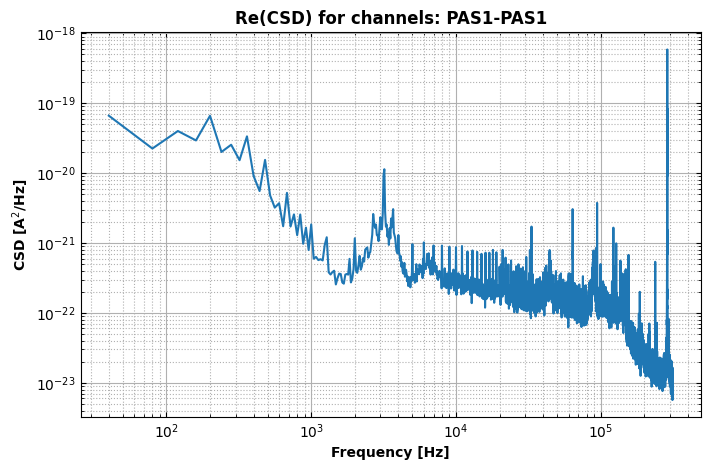

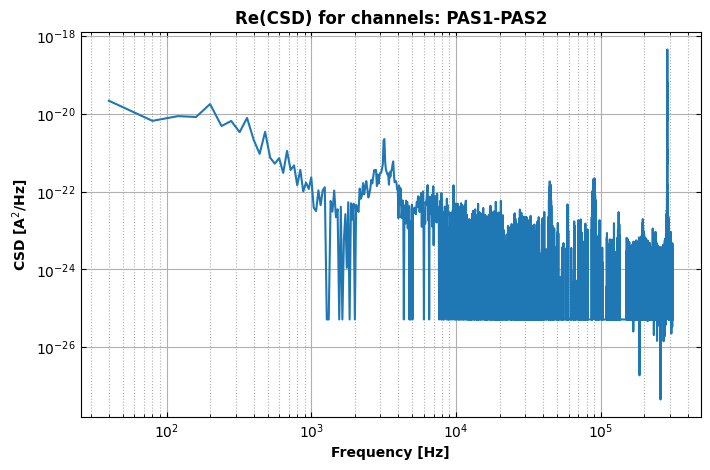

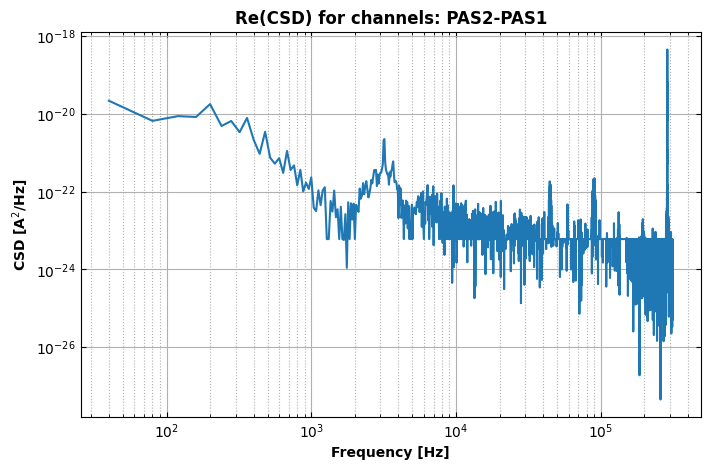

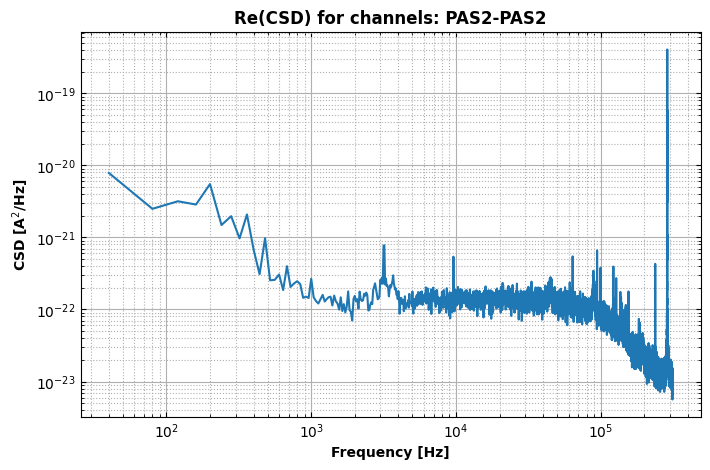

In [30]:
plot_csd(csd=csd, csd_freqs=csd_freqs, channels=['PAS1','PAS2'], whichcsd=['00','01','10','11'])

In [42]:
# instantiate Noise 
noise = {}
for f in files_selected[r]:
    csd_traces = np.transpose(traces[f],axes=(1,0,2))
    i=0
    temp = {}
    for c in [['PAS1','PBS1']]:#,['PCS1','PFS1'], ['PAS2', 'PES2'],['PBS2','PFS2'],['PDS2','PCS2']]: # For same devices
    #for c in [['PAS1','PCS1'],['PAS2', 'PBS2']]: # Between two devices
        key = title_map[16][c[0]][:-2]
        temp[key] = Noise(traces=csd_traces[:,i*2:(i+1)*2,:],
                   fs=fs, 
                   channames= c,
                   name= 'DMQIS') #initialize a noise object
        temp[key].calculate_psd()
        temp[key].calculate_corrcoeff()
        temp[key].calculate_csd()
        temp[key].calculate_uncorr_noise()
        i+=1
    noise[f] = temp

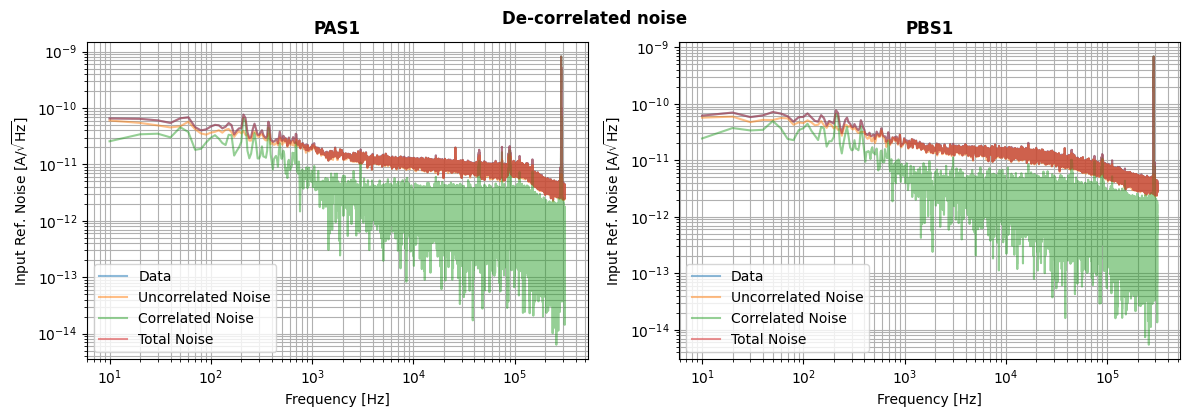

In [44]:
f = list(files_selected[r])[0]
for c in [['PAS1','PBS1']]:#,['PCS1','PFS1'], ['PAS2', 'PES2'],['PBS2','PFS2'],['PDS2','PCS2']]:
#for c in [['PAS1','PCS1'],['PAS2', 'PBS2']]:
    key = title_map[16][c[0]][:-2]
    noise[f][key].plot_decorrelatednoise(lgccorrelated=True,lgcsum = True, lgcsave=False)

## Noise modeling

### Normal noise

Fitting SQUID noise

In [45]:
files_n = {16:['RUN17965_DUMP0000.mid.gz']}

event_dframe_n={}
odb_n={}
for r in runs[2:]:
    for f in files_n[r]:
        #EN = list(EN_Ba['EventNumber'][:50].astype(int))
        fpath = raw_filepath[r]
        if('16439' in f): fpath = raw_filepath[r][:-2]+'4/'
        myreader = cdms.rawio.IO.RawDataReader(filepath=fpath+f,verbose=False)
        temp=myreader.read_events(output_format = 2)
        odb_n[f] = myreader.get_full_odb()
        event_dframe_n[f]=temp

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN17965_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN17965_DUMP0000.mid.gz
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN17965_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN17965_DUMP0000.mid.gz
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN17965_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn

In [46]:
odb_n[f]['/Detectors/Det01/Settings/Phonon/QETBias (uA)']

[1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0]

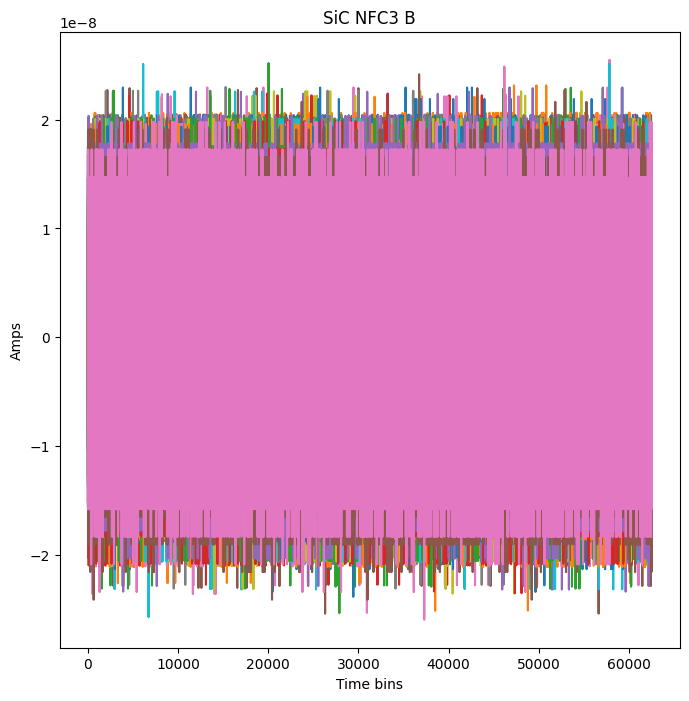

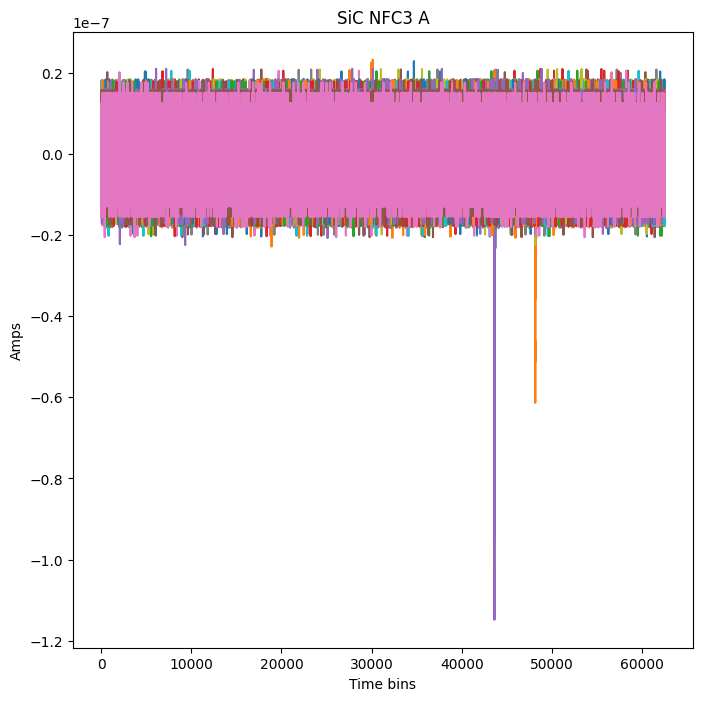

In [48]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})
fs = 625e3

psd_traces_n = {}
for r in runs[2:]:
    for f in files_n[r]:
        n = len(event_dframe_n[f])
        tempchan = {}
        
        for c in ['PAS1','PBS1']:#,'PCS1','PFS1', 'PAS2', 'PES2','PBS2','PFS2','PDS2','PCS2']: #For same detector correlation
        #for c in ['PAS1','PCS1','PAS2', 'PBS2']: # For inter-detector correlation
            # if(r == 15): ch = c
            # if(r == 12): ch = r12_chanmap[c]
            ch = c
            temp=[]
            for i in range(n):
                trace = (event_dframe_n[f][i][f"Z{detector}"][ch]-phonon_shift)*ADC2amps#- offsets[ch][r]*1e-6
                trace -= np.mean(trace[:10000])
               
                temp.append(trace)

            #cut=autocuts(np.array(temp),fs=fs)
            tempchan[ch] = np.array(temp)#[cut]
            for i in range(len(temp)):
                plt.plot(temp[i])
            plt.title(title_map[15][c])
            plt.xlabel('Time bins')
            plt.ylabel('Amps')
            #plt.xlim(0,500)
            plt.show()
        psd_traces_n[f] = tempchan

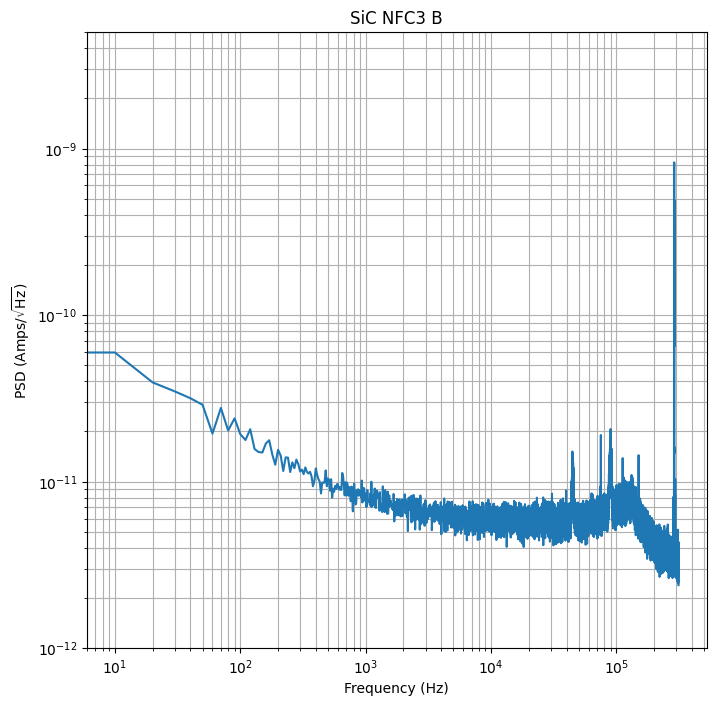

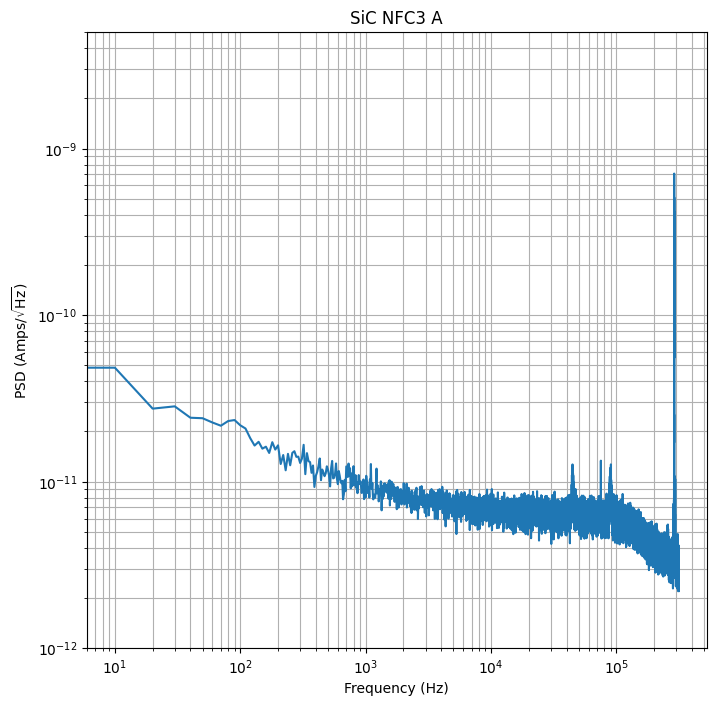

In [49]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})
avg_psd_n={}
freqs_n = {}
fs = 625e3
traces_n = []

# The channels below are in the order of the pairs for which csd is to be calculated
for c in ['PAS1','PBS1']:#,'PCS1','PFS1', 'PAS2', 'PES2','PBS2','PFS2','PDS2','PCS2']:  #For same detector correlation
#for c in ['PAS1','PCS1','PAS2', 'PBS2']: # For inter-detector correlation
    for r in runs[2:]:
        ch = c
        #if(r == 15): ch = c
        #if(r == 12): ch  = r12_chanmap[c]
        for f in files_n[r]:
            traces_n.append(psd_traces_n[f][ch])
            freqs_n[f+' '+ch], avg_psd_n[f+' '+ch] = calc_psd(np.array(psd_traces_n[f][ch]), fs = fs, folded_over=True)
            plt.loglog(freqs_n[f+' '+ch], np.sqrt(avg_psd_n[f+' '+ch]))

    #plt.legend()
    plt.grid(which='both',axis='both')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'PSD (Amps/$\sqrt{\text{Hz}}$)')
    plt.title(title_map[16][c])
    plt.ylim(1e-12,5e-9)
    plt.show()

In [50]:
# instantiate Noise 
csd_traces_n = np.transpose(traces_n,axes=(1,0,2))
noise_norm = {}
i=0
for c in [['PAS1','PBS1']]:#,['PCS1','PFS1'], ['PAS2', 'PES2'],['PBS2','PFS2'],['PDS2','PCS2']]: # For same devices
#for c in [['PAS1','PCS1'],['PAS2', 'PBS2']]: # Between two devices
    key = title_map[16][c[0]][:-2]
    noise_norm[key] = Noise(traces=csd_traces_n[:,i*2:(i+1)*2,:],
                   fs=fs, 
                   channames= c,
                   name= 'DMQIS') #initialize a noise object
    noise_norm[key].calculate_psd()
    noise_norm[key].calculate_corrcoeff()
    noise_norm[key].calculate_csd()
    noise_norm[key].calculate_uncorr_noise()
    i+=1

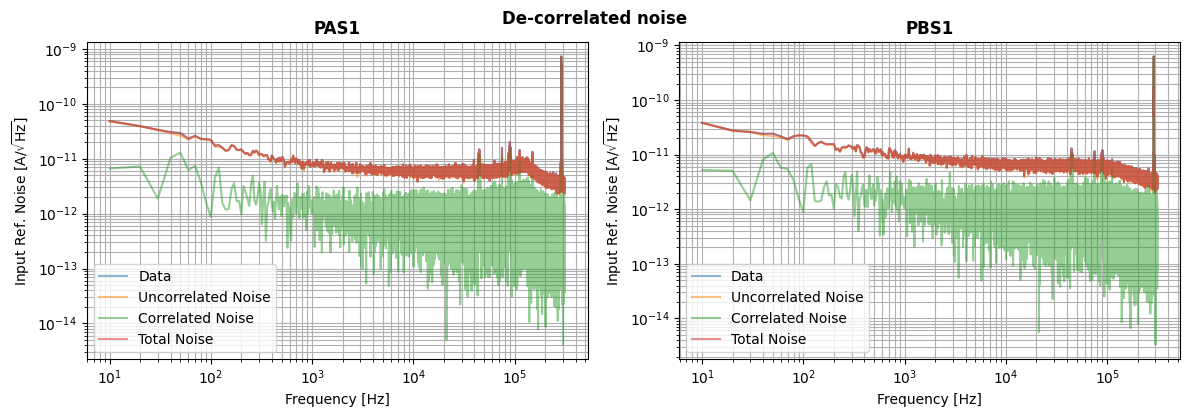

In [51]:
for c in [['PAS1','PBS1']]:#,['PCS1','PFS1'], ['PAS2', 'PES2'],['PBS2','PFS2'],['PDS2','PCS2']]:
#for c in [['PAS1','PCS1'],['PAS2', 'PBS2']]:
    key = title_map[16][c[0]][:-2]
    noise_norm[key].plot_decorrelatednoise(lgccorrelated=True,lgcsum = True, lgcsave=False)

{'freqs': array([1.00000000e+00, 1.00126735e+00, 1.00253631e+00, ...,
       3.15427744e+05, 3.15827502e+05, 3.16227766e+05]), 'rload': 0.03297, 'r0': 0.77, 'rshunt': 0.005, 'beta': 0.0, 'loopgain': 0.0, 'inductance': 5.49e-07, 'tau0': 0.0005, 'qetbias': 0.001, 'i0': 6.226882697983736e-06, 'tc': 0.056, 'tload': 0.07, 'G': 1.61e-10, 'tbath': 0.045, 'n': 4.65, 'lgcb': True, 'squiddc': 3.85e-12, 'squidpole': 300, 'squidn': 0.65, 'f_tfn': 0.6453310310230467}


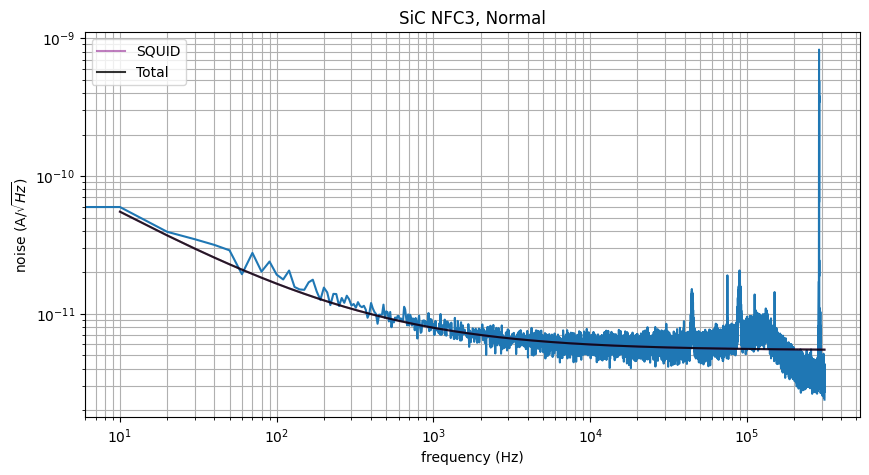

In [113]:
tracelen = len(traces_n[0][0])
f = np.fft.fftfreq(tracelen, d=1/fs)
noise_n = qp.sim.TESnoise(tc=0.056, n = 4.65 , G = 1.61e-10, rload = 32.97e-3, tbath = 0.045, qetbias = 1000.0e-6, r0 = 0.77, tload = 0.07)
noise_n.squidn = 0.65
noise_n.squidpole = 300
noise_n.squiddc = 3.85e-12

noise_n.inductance = 0.549e-6
noise_n.loopgain = 0.0
noise_n.beta = 0.0
#noisesim.io= 1.5e-6

print(noise_n.__dict__)

squid_sim = noise_n.s_isquid(freqs=f)

psd_sim = squid_sim 

f_squid, squid_sim_fold = qp.foldpsd(squid_sim, fs=fs)
f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

ch = 'PAS1' # For NFC3 B
f = files_n[r][0]

det_sel = 'SiC NFC3'
decorr_psd_n = noise_norm[det_sel].uncorrnoise
#freqs_n = noise_norm[det_sel].freqs

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 10})

plt.loglog(freqs_n[f+' '+ch], np.sqrt(avg_psd_n[f+' '+ch]))
#plt.loglog(freqs_n, np.sqrt(decorr_psd_n[1]))

plt.loglog(f_squid, squid_sim_fold**0.5, color="purple", alpha=0.5, label="SQUID")

plt.loglog(f_fold, psd_sim_fold**0.5, color="black", alpha=0.8, label="Total")

plt.legend()
#plt.ylim(top = 1e-8, bottom =1e-13)
plt.xlabel('frequency (Hz)')
plt.ylabel(r'noise (A/$\sqrt{Hz})$')
plt.title(det_sel+', Normal')
plt.grid(which="both")

plt.show()

### SC noise

Fitting load noise. We fix SQUID noise from Normal fit.

In [63]:
files_sc = {16:['RUN18057_DUMP0000.mid.gz']}

event_dframe_sc={}
odb_sc={}
for r in runs[2:]:
    for f in files_sc[r]:
        #EN = list(EN_Ba['EventNumber'][:50].astype(int))
        fpath = raw_filepath[r]
        if('16439' in f): fpath = raw_filepath[r][:-2]+'4/'
        myreader = cdms.rawio.IO.RawDataReader(filepath=fpath+f,verbose=False)
        temp=myreader.read_events(output_format = 2)
        odb_sc[f] = myreader.get_full_odb()
        event_dframe_sc[f]=temp

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18057_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18057_DUMP0000.mid.gz
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18057_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18057_DUMP0000.mid.gz
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN18057_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn

In [64]:
odb_sc[f]['/Detectors/Det01/Settings/Phonon/QETBias (uA)']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

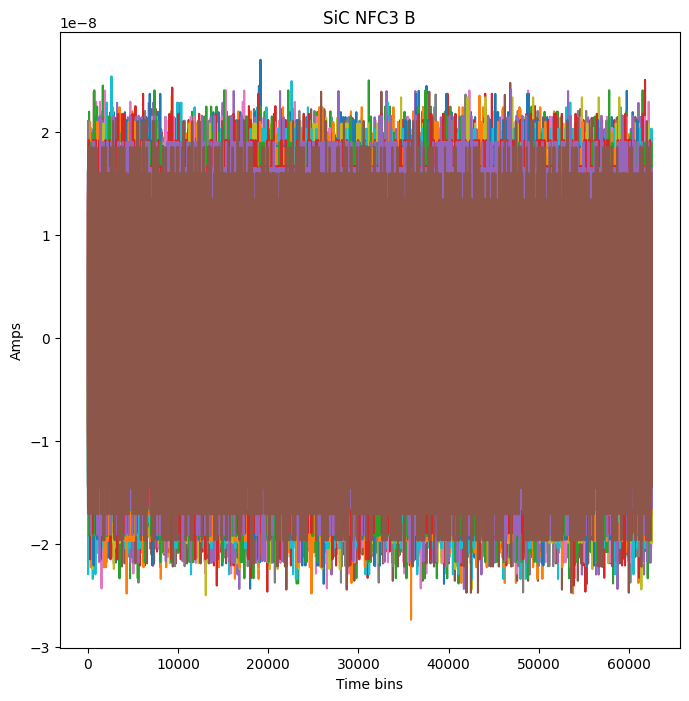

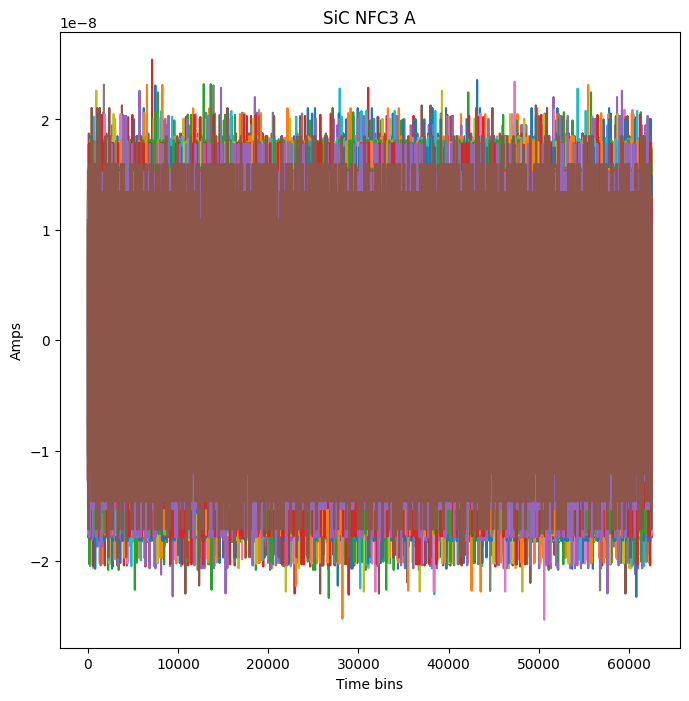

In [65]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})
fs = 625e3

psd_traces_sc = {}
for r in runs[2:]:
    for f in files_sc[r]:
        n = len(event_dframe_sc[f])
        tempchan = {}
        
        for c in ['PAS1','PBS1']:#,'PCS1','PFS1', 'PAS2', 'PES2','PBS2','PFS2','PDS2','PCS2']:
        #for c in ['PAS1','PCS1','PAS2', 'PBS2']:
            # if(r == 15): ch = c
            # if(r == 12): ch = r12_chanmap[c]
            ch = c
            temp=[]
            for i in range(n):
                trace = (event_dframe_sc[f][i][f"Z{detector}"][ch]-phonon_shift)*ADC2amps#- offsets[ch][r]*1e-6
                trace -= np.mean(trace[:10000])
               
                temp.append(trace)

            #cut=autocuts(np.array(temp),fs=fs)
            tempchan[ch] = np.array(temp)#[cut]
            for i in range(len(temp)):
                plt.plot(temp[i])
            plt.title(title_map[15][c])
            plt.xlabel('Time bins')
            plt.ylabel('Amps')
            #plt.xlim(0,500)
            plt.show()
        psd_traces_sc[f] = tempchan

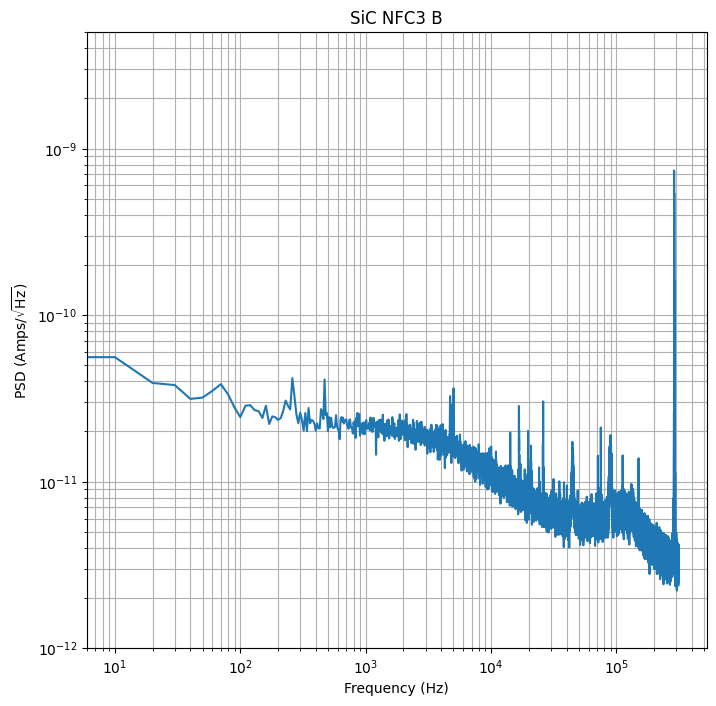

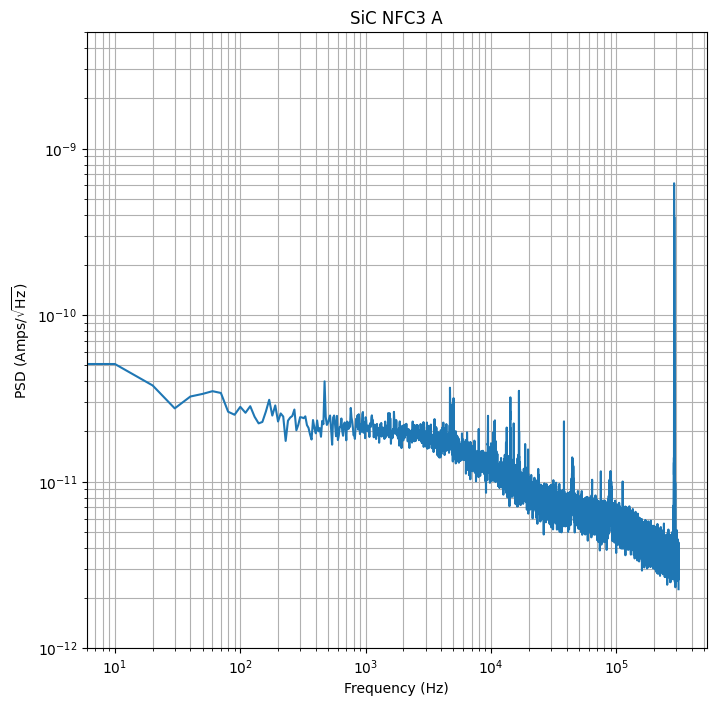

In [66]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})
avg_psd_sc={}
freqs_sc = {}
fs = 625e3
traces_sc = []
for c in ['PAS1','PBS1']:#,'PCS1','PFS1', 'PAS2', 'PES2','PBS2','PFS2','PDS2','PCS2']:#
#for c in ['PAS1','PCS1','PAS2', 'PBS2']:
    for r in runs[2:]:
        ch = c
        #if(r == 15): ch = c
        #if(r == 12): ch  = r12_chanmap[c]
        for f in files_sc[r]:
            traces_sc.append(psd_traces_sc[f][ch])
            freqs_sc[f+' '+ch], avg_psd_sc[f+' '+ch] = calc_psd(np.array(psd_traces_sc[f][ch]), fs = fs, folded_over=True)
            plt.loglog(freqs_sc[f+' '+ch], np.sqrt(avg_psd_sc[f+' '+ch]))

    #plt.legend()
    plt.grid(which='both',axis='both')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'PSD (Amps/$\sqrt{\text{Hz}}$)')
    plt.title(title_map[16][c])
    plt.ylim(1e-12,5e-9)
    plt.show()

In [67]:
# instantiate Noise 
csd_traces_sc = np.transpose(traces_sc,axes=(1,0,2))
noise_sc = {}
i=0
for c in [['PAS1','PBS1']]:#,['PCS1','PFS1'], ['PAS2', 'PES2'],['PBS2','PFS2'],['PDS2','PCS2']]: # For same devices
#for c in [['PAS1','PCS1'],['PAS2', 'PBS2']]: # Between two devices
    key = title_map[16][c[0]][:-2]
    noise_sc[key] = Noise(traces=csd_traces_sc[:,i*2:(i+1)*2,:],
                   fs=fs, 
                   channames= c,
                   name= 'DMQIS') #initialize a noise object
    noise_sc[key].calculate_psd()
    noise_sc[key].calculate_corrcoeff()
    noise_sc[key].calculate_csd()
    noise_sc[key].calculate_uncorr_noise()
    i+=1

In [21]:
noise_sc.keys()

dict_keys(['SiC NFC3', 'SiC NFH', 'SiC NFC1', 'SiC NFC2', 'TAMU NFC'])

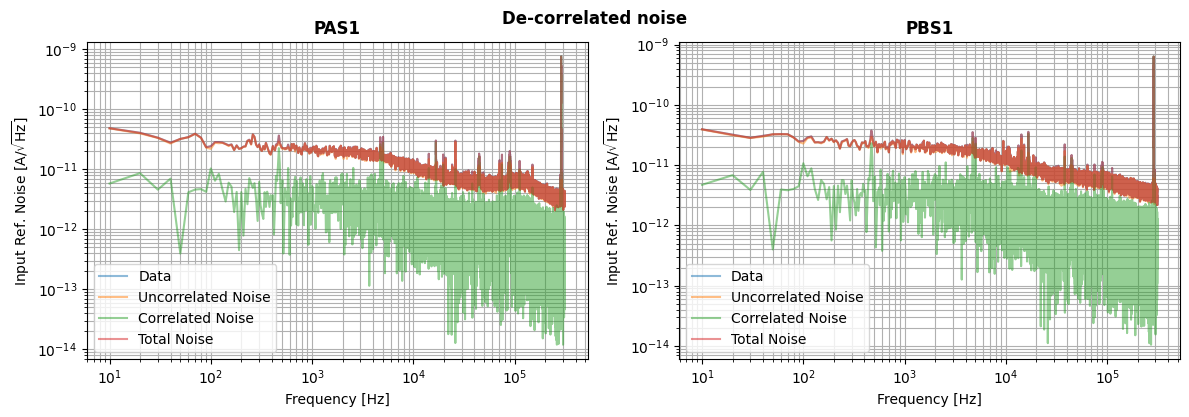

In [68]:
for c in [['PAS1','PBS1']]:#,['PCS1','PFS1'], ['PAS2', 'PES2'],['PBS2','PFS2'],['PDS2','PCS2']]:
#for c in [['PAS1','PCS1'],['PAS2', 'PBS2']]:
    key = title_map[16][c[0]][:-2]
    noise_sc[key].plot_decorrelatednoise(lgccorrelated=True,lgcsum = True, lgcsave=False)

{'freqs': array([1.00000000e+00, 1.00126735e+00, 1.00253631e+00, ...,
       3.15427744e+05, 3.15827502e+05, 3.16227766e+05]), 'rload': 0.0163, 'r0': 0.0, 'rshunt': 0.005, 'beta': 0.0, 'loopgain': 0.0, 'inductance': 5.49e-07, 'tau0': 0.0005, 'qetbias': 0.0, 'i0': 0.0, 'tc': 0.056, 'tload': 0.06, 'G': 1.61e-10, 'tbath': 0.045, 'n': 4.65, 'lgcb': True, 'squiddc': 3.85e-12, 'squidpole': 300, 'squidn': 0.65, 'f_tfn': 0.6453310310230467}


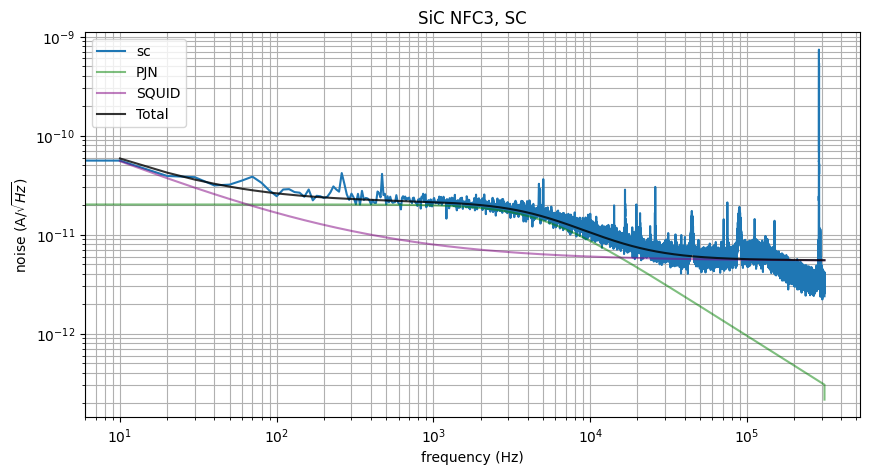

In [116]:
tracelen = len(traces_sc[0][0])
f = np.fft.fftfreq(tracelen, d=1/fs)
noisesc = qp.sim.TESnoise(tc=0.056, n = 4.65 , G = 1.61e-10, rload = 16.3e-3, tbath = 0.045, qetbias = 0.0, r0 = 0.0, tload = 0.06)

# Fixed from normal
noisesc.squidn = 0.65
noisesc.squidpole = 300
noisesc.squiddc = 3.85e-12

noisesc.inductance = 0.549e-6
noisesc.loopgain = 0.0
noisesc.beta = 0.0
#noisesim.io= 1.5e-6

print(noisesc.__dict__)

load_sim = noisesc.s_iloadsc(freqs=f)
squid_sim = noisesc.s_isquid(freqs=f)

psd_sim = squid_sim + load_sim

f_load, load_sim_fold = qp.foldpsd(load_sim, fs=fs)
f_squid, squid_sim_fold = qp.foldpsd(squid_sim, fs=fs)
f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

ch = 'PAS1' # For NFH B
f = files_sc[r][0]

det_sel = 'SiC NFC3'
decorr_psd_sc = noise_sc[det_sel].uncorrnoise
#freqs_sc = noise_sc[det_sel].freqs

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 10})

plt.loglog(freqs_sc[f+' '+ch], np.sqrt(avg_psd_sc[f+' '+ch]),label='sc')
#plt.loglog(freqs_sc, np.sqrt(decorr_psd_sc[1]))
# f = files_n[r][0]
# plt.loglog(freqs_n[f+' '+ch], np.sqrt(avg_psd_n[f+' '+ch]),label='normal')

plt.loglog(f_load, load_sim_fold**0.5, color="green", alpha=0.5, label="PJN")
plt.loglog(f_squid, squid_sim_fold**0.5, color="purple", alpha=0.5, label="SQUID")

plt.loglog(f_fold, psd_sim_fold**0.5, color="black", alpha=0.8, label="Total")

plt.legend()
#plt.ylim(top = 1e-8, bottom =1e-13)
plt.xlabel('frequency (Hz)')
plt.ylabel(r'noise (A/$\sqrt{Hz})$')
plt.title(det_sel+', SC')
plt.grid(which="both")

plt.show()

### Transition data

Fix SQUID and Load noise parameters. TES parameters should ideally be taken from dIdV. If not you will have to tune this by hand based on rough guesses.

In [47]:
f = 'RUN18041_DUMP0000.mid.gz'
odb[f]['/Detectors/Det01/Settings/Phonon/QETBias (uA)']

[80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0]

{'freqs': array([1.00000000e+00, 1.00126735e+00, 1.00253631e+00, ...,
       3.15427744e+05, 3.15827502e+05, 3.16227766e+05]), 'rload': 0.03297, 'r0': 0.0965, 'rshunt': 0.005, 'beta': 0.808, 'loopgain': 5.91, 'inductance': 5.49e-07, 'tau0': 0.000863586, 'qetbias': 7.5e-05, 'i0': 2.8964238819803814e-06, 'tc': 0.056, 'tload': 0.06, 'G': 4.7942032e-10, 'tbath': 0.045, 'n': 5, 'lgcb': True, 'squiddc': 3.85e-12, 'squidpole': 300, 'squidn': 0.65, 'f_tfn': 0.6346222748347983, 'io': 4.3e-06}


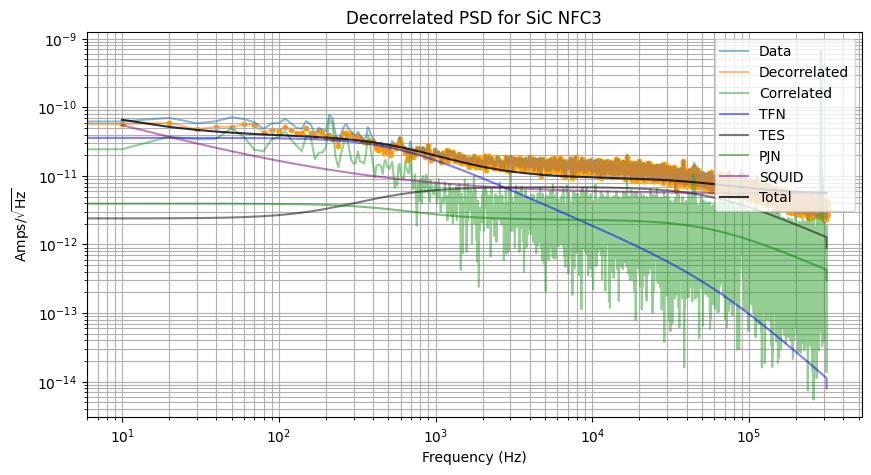

In [120]:
file = list(files_selected[r])[0]
tracelen = len(traces[file][0][0])
f = np.fft.fftfreq(tracelen, d=1/fs)
noisesim = qp.sim.TESnoise(tc=0.056, n = 5 , G = 2.3971016e-10*2, rload = 32.97e-3, tbath = 0.045, qetbias = 75e-6, r0 = 0.0965, tload = 0.060)

# Fixed from normal
noisesim.squidn = 0.65
noisesim.squidpole = 300
noisesim.squiddc = 3.85e-12

noisesim.inductance = 0.549e-6
noisesim.loopgain = 5.91
noisesim.beta = 0.808
noisesim.io= 4.3e-6
noisesim.tau0= 863.586e-6

print(noisesim.__dict__)

tfn_sim = noisesim.s_itfn(freqs=f)
tes_sim = noisesim.s_ites(freqs=f)
load_sim = noisesim.s_iload(freqs=f)
squid_sim = noisesim.s_isquid(freqs=f)

psd_sim = load_sim + tes_sim + tfn_sim + squid_sim

f_tfn, tfn_sim_fold = qp.foldpsd(tfn_sim, fs=fs)
f_tes, tes_sim_fold = qp.foldpsd(tes_sim, fs=fs)
f_load, load_sim_fold = qp.foldpsd(load_sim, fs=fs)
f_squid, squid_sim_fold = qp.foldpsd(squid_sim, fs=fs)
f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)


# Get Transition CSD
det_sel = 'SiC NFC3'

f = list(files_selected[r])[0]
decorr_psd1 = noise[f][det_sel].uncorrnoise
corr_noise = noise[f][det_sel].corrnoise
full_psd = noise[f][det_sel].real_csd[1][1]
freqs1 = noise[f][det_sel].freqs

# f = 
# decorr_psd2 = noise[f][det_sel].uncorrnoise
# freqs2 = noise[f][det_sel].freqs

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 10})

#plt.loglog(freqs,np.sqrt(decorr_psd[0]),label='A')
plt.loglog(freqs1,np.sqrt(full_psd), alpha=0.5,label='Data')
plt.loglog(freqs1,np.sqrt(decorr_psd1[1]), alpha=0.5, label='Decorrelated')
plt.scatter(freqs1,np.sqrt(decorr_psd1[1]),s = 10,color='orange')
plt.loglog(freqs1,np.sqrt(corr_noise[1]), alpha=0.5, label = 'Correlated')#,label = '100 ms')

# plt.scatter(freqs2,np.sqrt(decorr_psd2[1]),s = 10)
# plt.loglog(freqs2,np.sqrt(decorr_psd2[1]),label = '25 ms')
plt.yscale('log')
plt.xscale('log')

plt.loglog(f_tfn, tfn_sim_fold**0.5, color="blue", alpha=0.5, label="TFN")
plt.loglog(f_tes, tes_sim_fold**0.5, color="black", alpha=0.5, label="TES")
plt.loglog(f_load, load_sim_fold**0.5, color="green", alpha=0.5, label="PJN")
plt.loglog(f_squid, squid_sim_fold**0.5, color="purple", alpha=0.5, label="SQUID")

plt.loglog(f_fold, psd_sim_fold**0.5, color="black", alpha=0.8, label="Total")

plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Amps/$\sqrt{\rm Hz}$')
plt.grid(which='both')
plt.title('Decorrelated PSD for '+det_sel)
plt.legend(loc='upper right')
plt.show()

### Comparing PT on/off PSD

In [4]:
ptstatus = ['PTon','PToff']
files_selected = {'PTon':['RUN19018_DUMP0000.mid.gz'], 'PToff':{'RUN19019_DUMP0001.mid.gz'}}#,'RUN17864_DUMP0000.mid.gz'}}
raw_filepath = {'PTon':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/','PToff':'/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/'}

title_map = {12:{'PAS1': 'NW A', 'PBS1':'NW B', 'PCS1':'TAMU NFC A', 'PDS1': 'SiC sq A', 'PES1': 'SiC sq B','PFS1':'TAMU NFC B',
                 'PAS2': 'SiC NFC1 B', 'PBS2': 'SiC NFC2 A', 'PCS2': 'SiC NFH B', 'PDS2': 'SiC NFH A', 'PES2':'SiC NFC1 A', 'PFS2': 'SiC NFC2 B'},
             15:{"PAS1": "SiC NFC3 B", "PBS1": "SiC NFC3 A","PCS1": "SiC NFH A","PDS1": "TAMU NFH A","PES1": "TAMU NFH B",
             "PFS1": "SiC NFH B","PAS2": "SiC NFC1 B","PBS2": "SiC NFC2 A","PCS2": "TAMU NFC B","PDS2": "TAMU NFC A",
             "PES2": "SiC NFC1 A","PFS2": "SiC NFC2 B"},
            16:{"PAS1": "SiC NFC3 B", "PBS1": "SiC NFC3 A","PCS1": "SiC NFH A","PDS1": "TAMU NFH A","PES1": "TAMU NFH B",
             "PFS1": "SiC NFH B","PAS2": "SiC NFC1 B","PBS2": "SiC NFC2 A","PCS2": "TAMU NFC B","PDS2": "TAMU NFC A",
             "PES2": "SiC NFC1 A","PFS2": "SiC NFC2 B"}}

# Channels of interest in R12 are PFS1 (TAMU NFC B), PFS2 (SiC NFC2 B), PAS2 (SiC NFC1 B), PCS2 (SiC NFH B)

chan_tes = ['PBS1','PAS1','PCS1','PFS1','PDS1','PES1','PBS2','PFS2','PES2','PAS2','PDS2','PCS2'] # Chan names in TES order

In [5]:
event_dframe={}
odb={}
for r in ptstatus:
    for f in files_selected[r]:
        #EN = list(EN_Ba['EventNumber'][:50].astype(int))
        fpath = raw_filepath[r]
        if('16439' in f): fpath = raw_filepath[r][:-2]+'4/'
        print('here')
        myreader = cdms.rawio.IO.RawDataReader(filepath=fpath+f,verbose=False)
        print('here')
        temp=myreader.read_events(output_format = 2)
        print('here')
        odb[f] = myreader.get_full_odb()
        print('here')
        event_dframe[f]=temp

here
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19018_DUMP0000.mid.gz
here
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19018_DUMP0000.mid.gz
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19018_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19018_DUMP0000.mid.gz
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19018_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas fil

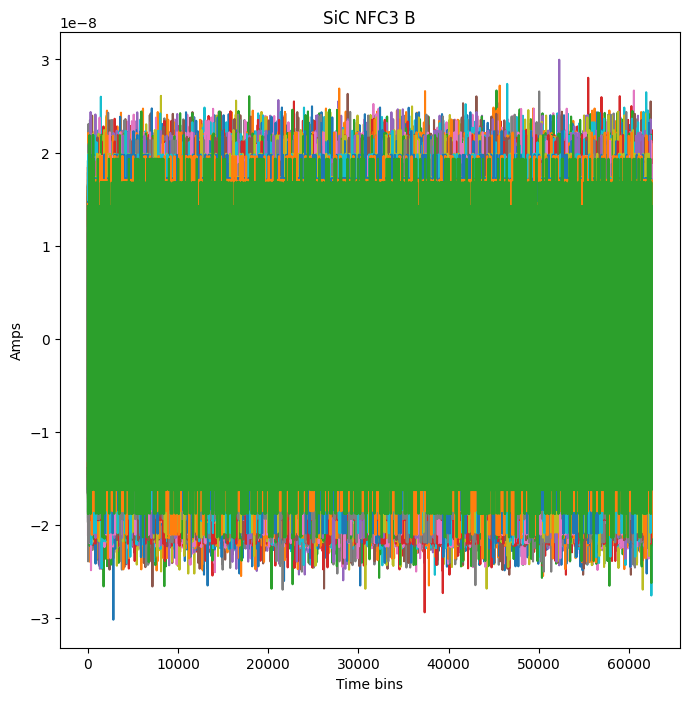

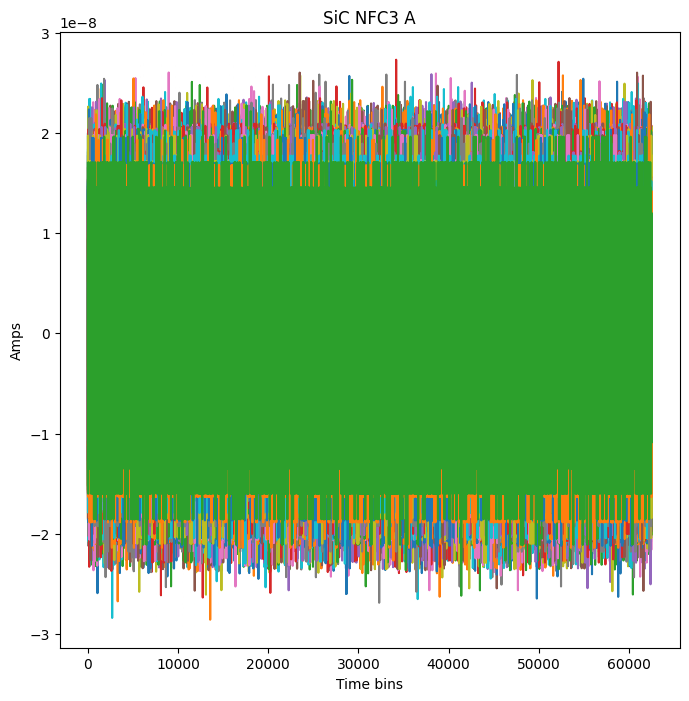

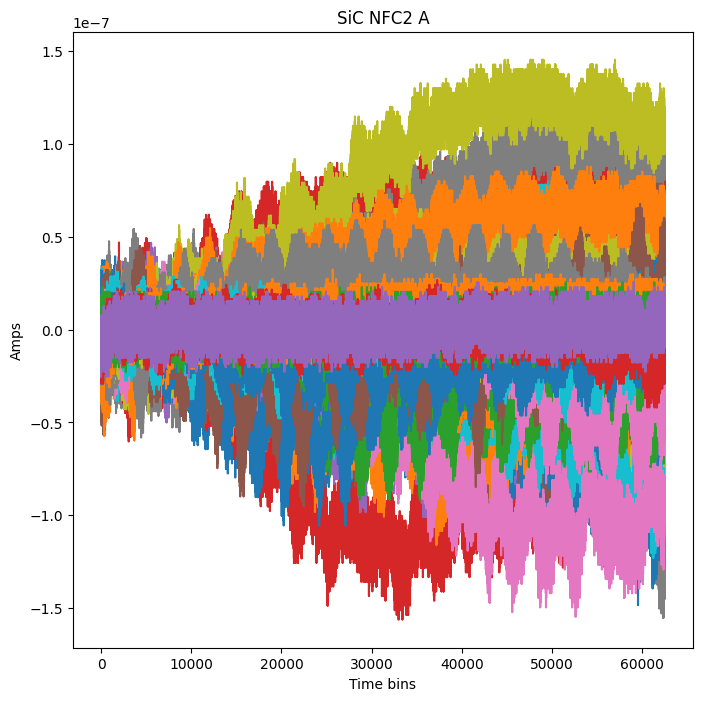

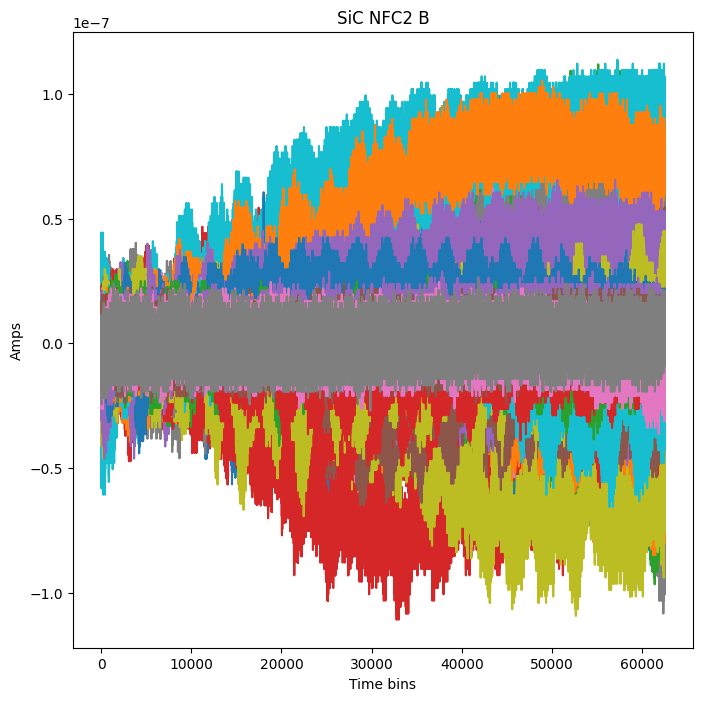

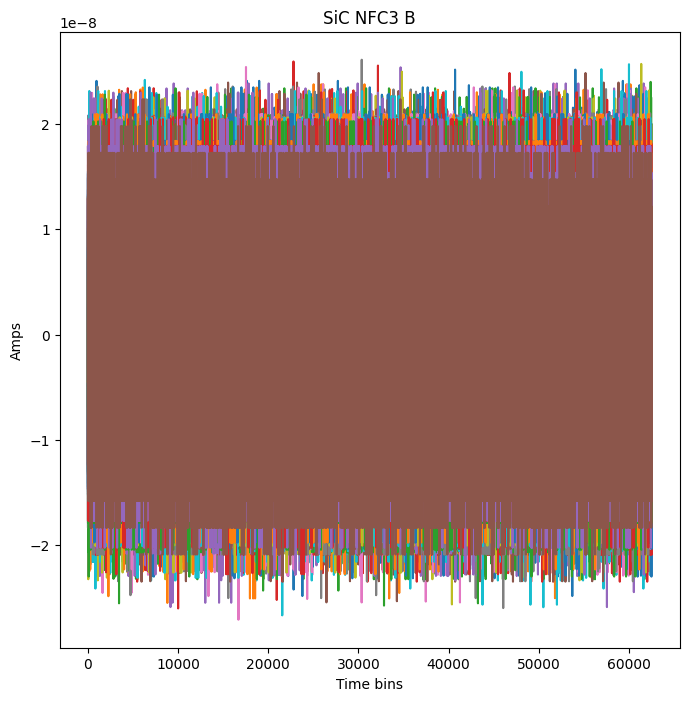

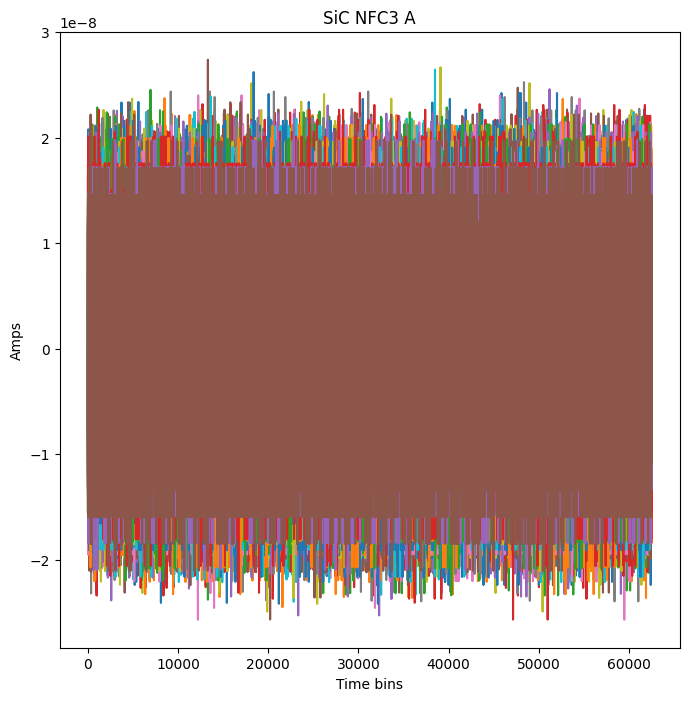

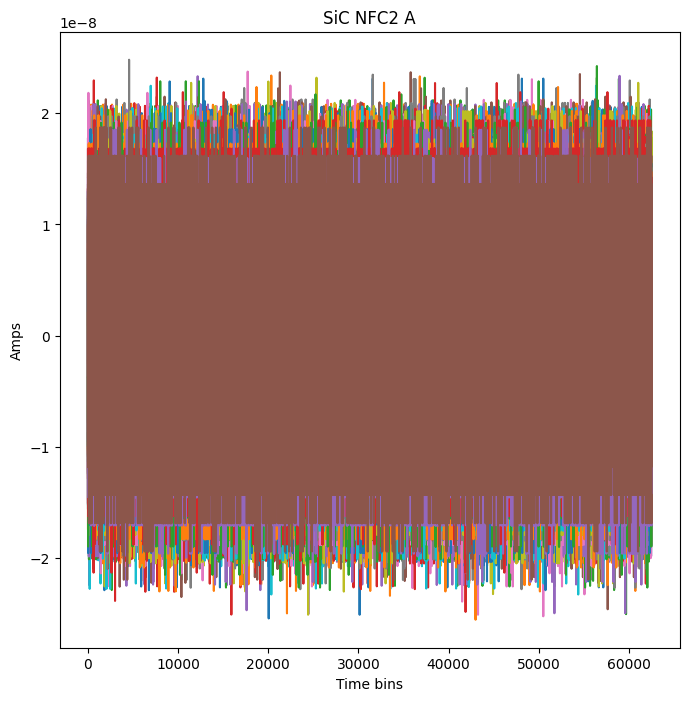

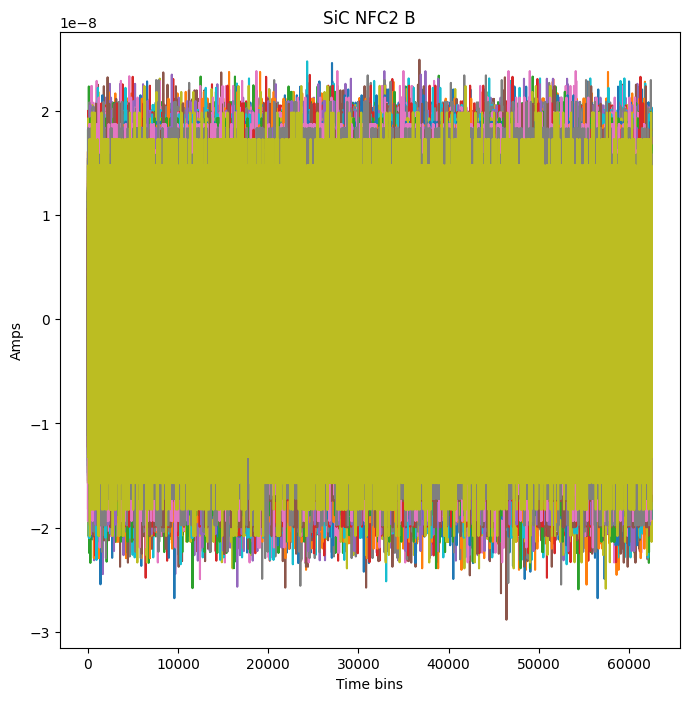

In [21]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})
fs = 625e3

psd_traces = {}
for r in ptstatus:
    for f in files_selected[r]:
        n = len(event_dframe[f])
        tempchan = {}
        
        for c in ['PAS1','PBS1','PBS2','PFS2']:#, 'PCS1','PFS1', 'PAS2', 'PES2', 'PDS2','PCS2']:
        #for c in ['PAS1','PCS1','PAS2', 'PBS2']:
            # if(r == 15): ch = c
            # if(r == 12): ch = r12_chanmap[c]
            ch = c
            temp=[]
            for i in range(n):
                trace = (event_dframe[f][i][f"Z{detector}"][ch]-phonon_shift)*ADC2amps#- offsets[ch][r]*1e-6
                trace -= np.mean(trace[:10000])

                if(max(trace)>0.3e-7 and ('PAS1' in c or 'PBS1' in c)):continue
                if(min(trace)<-0.25e-6 and ('PBS2' in c or 'PFS2' in c)):continue
                if(max(trace)>0.15e-6 and ('PBS2' in c or 'PFS2' in c) and (r=='PTon')):continue
                if(max(trace)>2.5e-8 and ('PBS2' in c or 'PFS2' in c) and (r=='PToff')):continue
                
                temp.append(trace)

            #cut=autocuts(np.array(temp),fs=fs)
            tempchan[ch] = np.array(temp)#[cut]
            for i in range(len(temp)):
                plt.plot(temp[i])
            plt.title(title_map[15][c])
            plt.xlabel('Time bins')
            plt.ylabel('Amps')
            #plt.xlim(0,500)
            plt.show()
        psd_traces[f] = tempchan

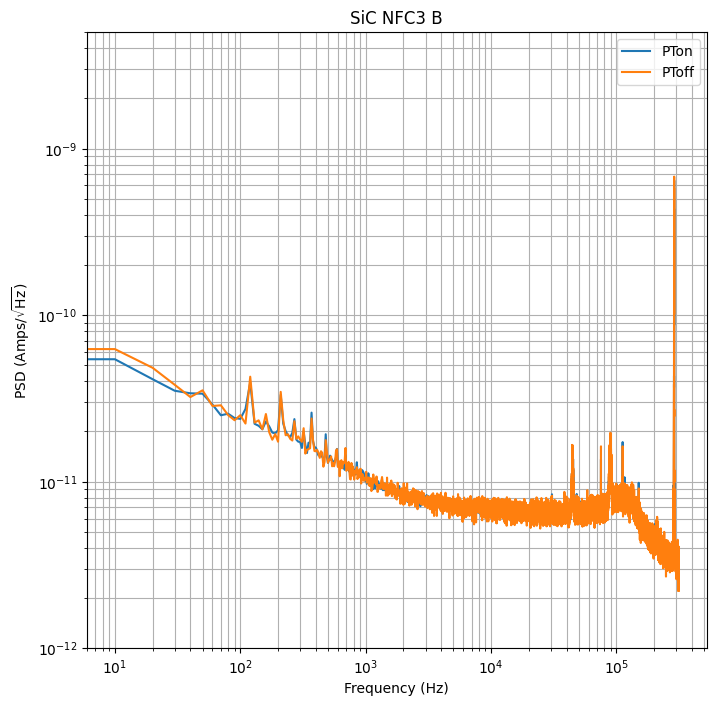

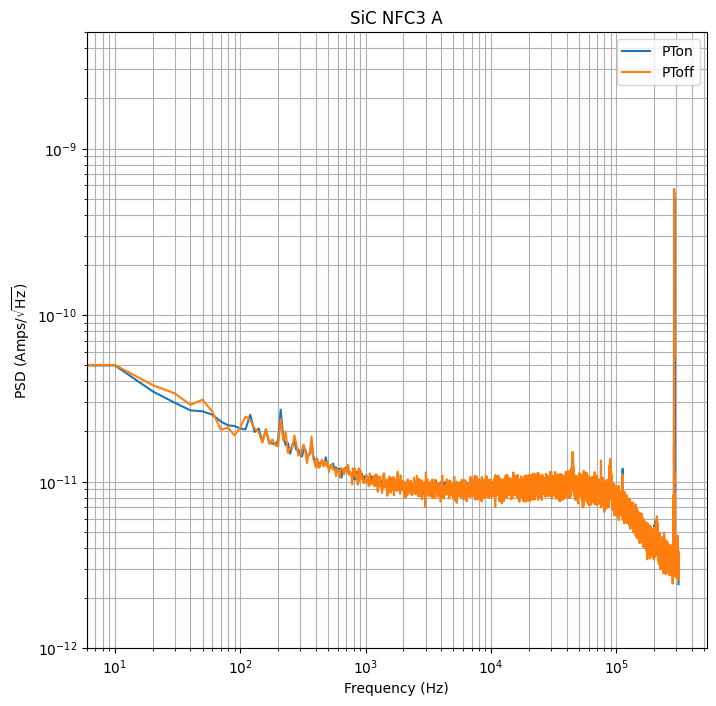

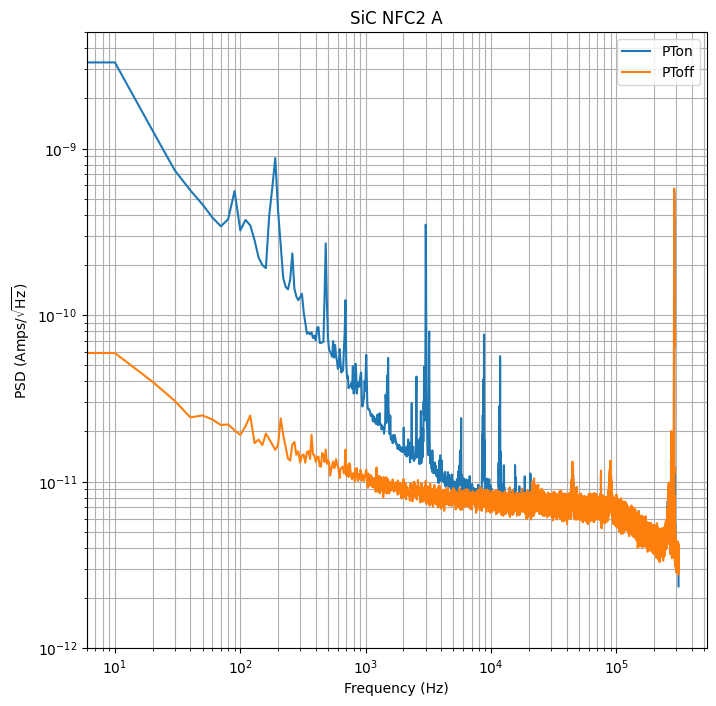

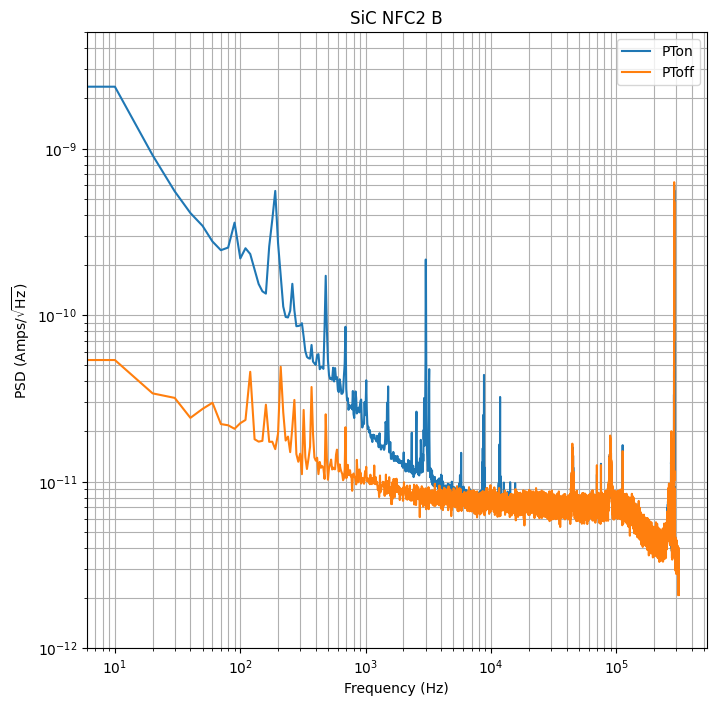

In [22]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})
avg_psd={}
freqs = {}
fs = 625e3
traces = []
for c in ['PAS1','PBS1','PBS2','PFS2']:#, 'PCS1','PFS1', 'PAS2', 'PES2', 'PDS2','PCS2']:
#for c in ['PAS1','PCS1','PAS2', 'PBS2']:
    for r in ptstatus:
        ch = c
        #if(r == 15): ch = c
        #if(r == 12): ch  = r12_chanmap[c]
        for f in files_selected[r]:
            traces.append(psd_traces[f][ch])
            freqs[f+' '+ch], avg_psd[f+' '+ch] = calc_psd(np.array(psd_traces[f][ch]), fs = fs, folded_over=True)
            plt.loglog(freqs[f+' '+ch], np.sqrt(avg_psd[f+' '+ch]),label = r)

    plt.legend()
    plt.grid(which='both',axis='both')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'PSD (Amps/$\sqrt{\text{Hz}}$)')
    plt.title(title_map[16][c])
    plt.ylim(1e-12,5e-9)
    plt.show()

### Power noise in transition

In [121]:
def unfold_psd(psd_folded,fs,N):
    #N = len(psd_folded)*2-1
    print(N)
    psd_unfolded= np.zeros(N)
    psd_unfolded[0] = psd_folded[0] 
    psd_unfolded[1:N//2] = 0.5 * psd_folded[1:N//2]
    if N % 2 == 0:
       psd_unfolded[N//2] = psd_folded[N//2]
    psd_unfolded[N//2 +1:] = psd_unfolded[1:N//2][::-1]
    freqs_unfolded = np.fft.fftfreq(N, d=1/fs)

    return freqs_unfolded, psd_unfolded

62512
62512
62512


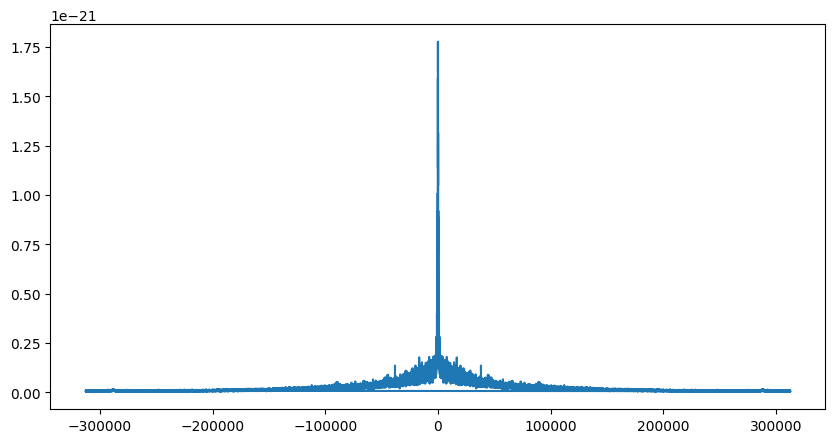

In [122]:
f_decorr, decorr_psd1_double = unfold_psd(decorr_psd1[1],625e3,tracelen)
f_full, full_psd_double = unfold_psd(full_psd,625e3,tracelen)
f_corr, corr_psd_double = unfold_psd(corr_noise[1],625e3,tracelen)
plt.plot(f_decorr,decorr_psd1_double)
plt.show()

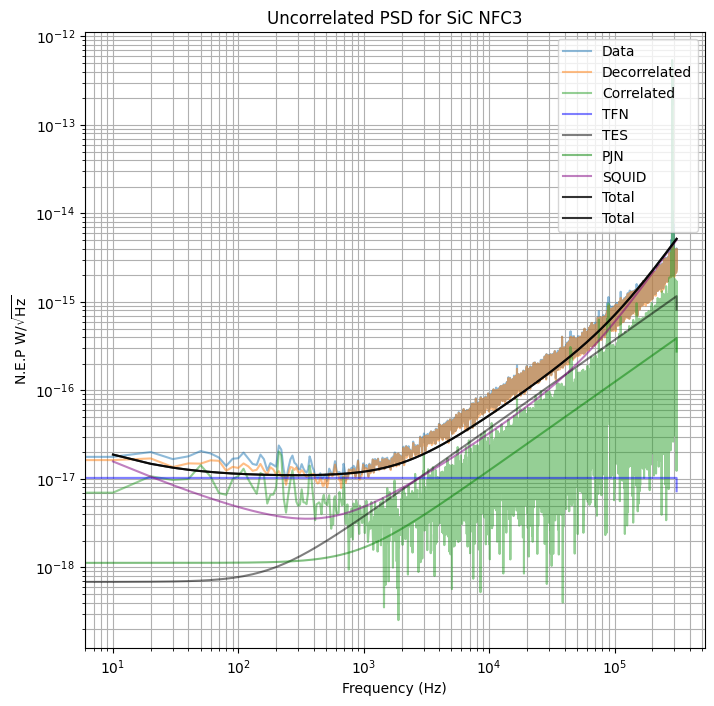

In [123]:
file = list(files_selected[r])[0]
tracelen = len(traces[file][0][0])
f = np.fft.fftfreq(tracelen, d=1/fs)
dIdP =  noisesim.dIdP(f)

nep_decorr = decorr_psd1_double/np.abs(dIdP)**2
nep_full_psd = full_psd_double/np.abs(dIdP)**2
nep_corr = corr_psd_double/np.abs(dIdP)**2

nep_tfn = tfn_sim/np.abs(dIdP)**2
nep_tes = tes_sim/np.abs(dIdP)**2
nep_load = load_sim/np.abs(dIdP)**2
nep_squid = squid_sim/np.abs(dIdP)**2

nep_psd = nep_load + nep_tes + nep_tfn + nep_squid

# let's fold the PSD 
f_psd, nep_decorr_fold = qp.foldpsd(nep_decorr, fs=fs)
f_full, nep_full_fold = qp.foldpsd(nep_full_psd, fs=fs)
f_corr, nep_corr_fold = qp.foldpsd(nep_corr, fs=fs)

f_tfn_fold, nep_tfn_fold = qp.foldpsd(nep_tfn, fs=fs)
f_tes_fold, nep_tes_fold = qp.foldpsd(nep_tes, fs=fs)
f_load_fold, nep_load_fold = qp.foldpsd(nep_load, fs=fs)
f_squid_fold, nep_squid_fold = qp.foldpsd(nep_squid, fs=fs)
f_fold_fold, nep_psd_fold = qp.foldpsd(nep_psd, fs=fs)


nep_psd = nep_load + nep_tes + nep_tfn + nep_squid

# let's fold the PSD 
f_psd, nep_decorr_fold = qp.foldpsd(nep_decorr, fs=fs)
f_full, nep_full_fold = qp.foldpsd(nep_full_psd, fs=fs)
f_corr, nep_corr_fold = qp.foldpsd(nep_corr, fs=fs)

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 10})

plt.loglog(f_full,np.sqrt(nep_full_fold), alpha=0.5, label='Data')
plt.loglog(f_psd,np.sqrt(nep_decorr_fold), alpha=0.5, label='Decorrelated')
plt.loglog(f_corr,np.sqrt(nep_corr_fold), alpha=0.5, label='Correlated')

#plt.plot(f_full, np.abs(dPdI[:int(tracelen/2)+1])**2,label='dPdI',color='r')
# plt.plot(f_full, np.abs(tfn_sim[:int(tracelen/2)+1]),label='tfn_sim',color='b')
# plt.plot(f_full, np.abs(tfn_sim*np.abs(dPdI)**2)[:int(tracelen/2)+1],label='product',color='m')

plt.loglog(f_tfn_fold, nep_tfn_fold**0.5, color="blue", alpha=0.5, label="TFN")
plt.loglog(f_tes_fold, nep_tes_fold**0.5, color="black", alpha=0.5, label="TES")
plt.loglog(f_load_fold, nep_load_fold**0.5, color="green", alpha=0.5, label="PJN")
plt.loglog(f_squid_fold, nep_squid_fold**0.5, color="purple", alpha=0.5, label="SQUID")

plt.loglog(f_fold_fold, nep_psd_fold**0.5, color="black", alpha=0.8, label="Total")

plt.loglog(f_fold, nep_psd_fold**0.5, color="black", alpha=0.8, label="Total")

plt.xlabel('Frequency (Hz)')
plt.ylabel(r'N.E.P W/$\sqrt{\rm Hz}$')
plt.grid(which='both')
plt.title('Uncorrelated PSD for '+det_sel)
plt.legend(loc='upper right')
plt.show()

## Phonon resolution

In [124]:
from qetpy.core.didv._templates_didv import get_didv_template, convert_template_to_power

In [125]:
didv_results = np.load("didv_75uA_NFC3.npy",allow_pickle=True)
didv_results = didv_results[()] 
didv_results['smallsignalparams']['L'] = 0.549e-6
didv_results

{'lgcfix': array([False, False, False, False, False, False, False]),
 'params': {'A': 0.20738998519913762,
  'B': -0.3259891960345863,
  'C': -0.10000000000000002,
  'tau1': -0.00017572557664458723,
  'tau2': 9.494358814853542e-06,
  'tau3': 0.0003579633112323628,
  'dt': -0.006997052247073841},
 'cov': array([[ 8.60073229e-08,  1.88534773e-08,  3.79384454e-07,
          6.11587259e-11, -2.48379411e-12,  6.45754442e-10,
          6.77593940e-14],
        [ 1.88534534e-08,  3.59436340e-07,  1.27270115e-06,
          6.88790850e-11, -8.04284652e-12,  3.04307924e-09,
          1.15971148e-13],
        [ 3.79384373e-07,  1.27270124e-06,  5.66358315e-06,
          4.51895700e-10, -3.61979278e-11,  1.25116235e-08,
          6.37140696e-13],
        [ 6.11587221e-11,  6.88791012e-11,  4.51895741e-10,
          7.25303195e-14, -2.61373134e-15,  1.06848357e-12,
          1.03447312e-16],
        [-2.48379361e-12, -8.04284710e-12, -3.61979279e-11,
         -2.61373109e-15,  1.37874303e-15, -6.55

In [126]:
from qetpy.core.didv._uncertainties_didv import get_dPdI_with_uncertainties

In [127]:
file = list(files_selected[r])[0]
tracelen = len(traces[file][0][0])
f = np.fft.fftfreq(tracelen, d=1/fs)
dPdI, dPdI_err = get_dPdI_with_uncertainties(f,didv_results)

In [128]:
def single_exp(t,pretrig,fs,falltime, risetime):
    N = int(pretrig*fs)
    template = np.zeros(N)
    template = np.append(template,np.exp(-(t[N:])/falltime) - np.exp(-(t[N:])/risetime))
    return template

/sdf/home/a/aditi/.local/lib/python3.10/site-packages/qetpy/core/didv/_templates_didv.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  p_freqs[i] = np.exp(2.0j * np.pi * freqs[i] * start_time)


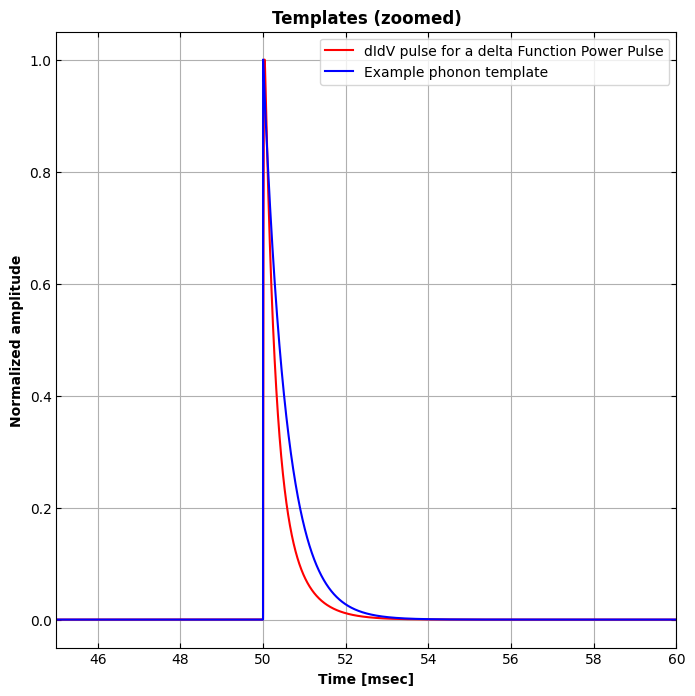

In [129]:
#  The template will be 20ms traces, with 10ms pre-trigger time
pretrigger = 50e-3 

# time array
dt = 1/fs
time_array = np.arange(tracelen)*dt

template_eg = single_exp(time_array,50e-3,625e3,554.36e-6,20e-6)
template_eg /= max(template_eg)
# Current Template  (dirac delta power input)
template_didv = get_didv_template(time_array, pretrigger, didv_results)
template_didv = template_didv/np.max(template_didv)

plt.plot(time_array*1e3, template_didv, color='r',
         label = "dIdV pulse for a delta Function Power Pulse")

plt.plot(time_array*1e3, template_eg, color='b',
         label = "Example phonon template")

plt.tick_params(which='both', direction='in', right=True, top=True)
plt.grid(which='minor', linestyle='dotted')
plt.grid(which='major')
plt.title('Templates (zoomed)',fontweight='bold')
plt.xlabel('Time [msec]',fontweight='bold')
plt.ylabel('Normalized amplitude',fontweight='bold')
plt.xlim(45,60)
plt.legend(loc='best')
plt.show()

In [130]:
# calculate resolution for didv template
# -> need to converto power
#template_didv_power = convert_template_to_power(template_didv, dpdi=dPdI)
resolution_template_didv = energy_resolution(decorr_psd1_double, template_didv, dPdI, fs,collection_eff=0.3, lgc_current_template=True)
resolution_template_eg = energy_resolution(decorr_psd1_double, template_eg, 1/dIdP, fs,collection_eff=0.3, lgc_current_template=True)

# print
print('Resolution with example template {:.2f} meV'.format(resolution_template_eg*1000))
print('Resolution with template from dirac delta power deposit: {:.2f} meV'.format(resolution_template_didv*1000))

Resolution with example template 3527.86 meV
Resolution with template from dirac delta power deposit: 3360.40 meV
